# 7. Reinforcement learning for Control 🐶

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/07_RL_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

```{attention} 
In this tutorial we are going to use the same CSTR example as in [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html). Therefore, it is a great idea to first look at tutorial 6 to have the complete context.
```



## Goals of this exercise 🌟
- Perform reactor control using reinforcement learning
- Revise the concept of transfer learning
- Revise the concept of policy gradients


## A quick reminder ✅

Reinforcement Learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. 

RL algorithms are particularly well suited to address sequential decision making problems under uncertainty, for example, they are generally applied to solve problems in a Markov decision process (MDP) setting. A control problem (just like reactor control) is a sequential decision making problem under uncertainty, where at every time-step the controller (agent in the RL context) must take an optimal (control) action, and it is hindered by process disturbances (uncertainty). There are many types of reinforcement leanring algorithms, in this notebook tutorial we will focus on **policy optimization** algorithms. 

We can define an RL agent as a controller that given a state ${\bf x}$ outputs the optimal action ${\bf u}$

$${\bf u}:=\pi({\bf x})$$

If the controller $\pi(\cdot)$ is parametrized, say by neural network weights $\boldsymbol{\theta}$, we can write 

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

where ${\bf \theta}$ are parameters determined *a priori*. We could define the PID controller in this same fashion:

$$u:=\text{PID}(x;K_P,K_I,K_D)$$

In many cases, to fullfil the exploration - exploitation dilemma or in games, stochastic policies are used, which instead of outputting a single action ${\bf u}$, output a distributions over actions $p({\bf x};\boldsymbol{\theta})$. 

$${\bf u} \sim p({\bf x};\boldsymbol{\theta})$$

In practice, it is common to have a neural network output the moments (mean and variance), and to then draw an action from the distribution parametrized by this mean and variance

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := p({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$

You can find a Taxonomy of RL Algorithms below.

```{figure} media/07_RL/algorithms.PNG
:alt: kNN
:width: 100%
:align: center

A broad classification of reinforcement learning algorithms. [source](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
```

In [1]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pylab import grid
import time

The code below corresponds to the CSTR model and parameters of tutorial 6.

In [2]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps

###############
#  CSTR model #
###############

# Taken from http://apmonitor.com/do/index.php/Main/NonlinearControl

def cstr(x,t,u):

    # ==  Inputs == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    
    # == Equations == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]    
Tc = np.zeros(len(t)-1);   

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T) 
data_res['Tc_dat'] = copy.deepcopy(Tc)

# noise level
noise             = 0.1
data_res['noise'] = noise

# control upper and lower bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

# desired setpoints
n_1                = int(n/2)
n_2                = n - n_1
Ca_des             = [0.8 for i in range(n_1)] + [0.9 for i in range(n_2)]
T_des              = [330 for i in range(n_1)] + [320 for i in range(n_2)]
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u  = min(max(u,data_res['Tc_lb']),data_res['Tc_ub'])

    return u

In [3]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, data_simulation):    
    
    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']
    
    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

## Stochastic Policy Search 🎲

### Policy network

In the same way as we used data-driven optimization to tune the gains $K_P,K_I,K_D$ in the PID controllers (cf. [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html)), we can use the same approach to tune (or train) the parameters (or weights) $\boldsymbol{\theta}$ of a neural network. 

There is research that suggest that evolutionary (or stochastic search in general) algorithms can be as good (or better in some contexts) than traditional techniques, for more details see [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/research/evolution-strategies), the paper can be found [here](https://arxiv.org/abs/1703.03864).

The difference here, with respect to the controller tuning that we perform on [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html) is that the neural networks have many parameters and the number of iterations needed are relatively high, and therefore, model/surrogate-based data-driven optimization methods do not scale as well and might not be the best choice. Therefore, stochastic search optimization methods (e.g. genetic algorithms, particle swarm optimization) can be a good alternative. You can check some pedagogical implementations [here](https://edgarsmdn.github.io/projects/stochastic_optimization_algorithms/).

In the following section we build a relatively simple neural network controller in PyTorch

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and hard code a simple stochastic search algorithm (it is a combination of random search and local random search) to manipulate the weights $\boldsymbol{\theta}$, evaluate the performance of the current weight values, and iterate.

**Neural Network Controller Training Algorithm**

*Initialization*

Collect $d$ initial datapoints $\mathcal{D}=\{(\hat{f}^{(j)}=\sum_{k=0}^{k=T_f} (e(k))^2,~ \boldsymbol{\theta}^{(j)}) \}_{j=0}^{j=d}$ by simulating $x(k+1) = f(x(\cdot),u(\cdot))$ for different values of $\boldsymbol{\theta}^{(j)}$, set a small radious of search $r$

*Main loop*

1. *Repeat*
2. $~~~~~~$ Choose best current known parameter value $\boldsymbol{\theta}^*$.
3. $~~~~~~$ Sample $n_s$ values around $\boldsymbol{\theta}^*$, that are at most some distance $r$, $\bar{\boldsymbol{\theta}}^{(0)},...,\bar{\boldsymbol{\theta}}^{(n_s)}$
3. $~~~~~~$ Simulate new values  $ x(k+1) = f(x(k),u(\bar{\boldsymbol{\theta}}^{(i)};x(k))), ~ k=0,...,T_f-1, i=0,...,n_s $
4. $~~~~~~$ Compute $\hat{f}^{(i)}=\sum_{k=0}^{k=T_f} (e(k))^2, i=0,...,n_s$.
5. $~~~~~~$ **if** $\bar{\boldsymbol{\theta}}^{\text{best}}$ is better than $\boldsymbol{\theta}^*$, then $ \boldsymbol{\theta}^* \leftarrow \bar{\boldsymbol{\theta}}^{\text{best}}$, **else** $ r \leftarrow r\gamma$, where $ 0 < \gamma <1 $ 
6. until stopping criterion is met.

Remarks: 
* The initial collection of $d$ points is generally done by some space filling (e.g. [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol Sequence](https://en.wikipedia.org/wiki/Sobol_sequence)) procedure.

First, let's create a neural network in PyTorch that has two hidden layers, one being double the size of the input layer and the other double the size of the output layer. We will use the activation functions [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) and [ReLU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html). If you want a more gentle introduction to neural nets in Pytorch, check the [tutorial notebook 4](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html).

In [5]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2
        self.hs2        = self.output_sz*2 

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.output  = torch.nn.Linear(self.hs2, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
        y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

We normalize the inputs and states

In [6]:
# normalization for states and actions 
data_res['x_norm'] = np.array([[.8, 315,0, 0],[.1, 10,.1, 20]]) # [mean],[range]
data_res['u_norm'] = np.array([[10/6],[295]])    # [range/6],[bias]

Now, let's create the objective function for the policy network. 

```{tip} Notice the difference between this objective function and the objective function use in [tutorial 6](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html). We have included a conditional to switch between algorithms.
```


In [17]:
def J_PolicyCSTR(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])    
    noise = data_res['noise']
    
    # setpoints      
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']
    
    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = x0
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate CSTR
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])

        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 1))
          print("The first value for u_k is:", u_k)
          u_k          = u_k*u_norm[0] + u_norm[1]
          u_k          = u_k[0]
          print("The second value for u_k is:", u_k)
          u_k          = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]        = u_k[0]
          print("The third value for u_k is:", Tc[i])

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1]      = y[-1][0] + noise*s[0]*0.1    
        T[i+1]       = y[-1][1] + noise*s[1]*5     
        # state update
        x[0]         = Ca[i+1]
        x[1]         = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha


As mentioned above, we are going to use a stochastic search algorithm that combines random search with local random search to optimize the policy network.

The code below has two main elements:

**Random Search Step**: During this step neural network weights are sampled uniformely (given some bounds). Each set of parameters is evaluated (a simulation is run), and the parameter set that performed best is passed to the next step.

An illustration of how Random Search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/random_search.PNG
:alt: kNN
:width: 75%
:align: center

An illustration of the random search algorithm. [source](https://commons.wikimedia.org/wiki/File:Hyperparameter_Optimization_using_Random_Search.svg)
```

**Local Search Step**: This step starts from the best parameter values found by the *Random Search Step*. Subsequently it does a random search close by the best value found (hence termed stocastic local search). Additionally, if after some number of interations a better function value has not been found (also via simulating the system), the radius of search is reduced. 

An illustration of how Local search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/local_random_search.PNG
:alt: kNN
:width: 70%
:align: center

An illustration of the local search algorithm.
```

By combining a 'global search' strategy (Random search) and a 'local search' strategy (Local search) we balance exploration and exploitation which is a key concept in reinforcement learning.

In [20]:
#######################
# auxiliary functions #
#######################

def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise rewards
    best_reward = 1e8
    best_policy = copy.deepcopy(params)
    
    # initialise population
    population = []
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
        
    for i in range(iterations+1):
        fun_population = [] # initialise empty list of rewards
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
            
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_guess = population[fitness_scores.index(max(fitness_scores))] # determine best current set of params
        new_generation = [best_guess] # it automatically becomes part of the new generation
        pop_aslist = [list(person.values()) for person in population] # turn the list of dict's into a list of lists, to be able to inde through them
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (parent1, parent2) = random.choices(population, selection_probs, k=2) # select two parents
            children = []
            child1 = []
            child2 = []
            index = random.randint(1, len(population[0])
            child1.extend(parent1[0:index])
            child1.extend(parent2[index:])
            child2.extend(parent1[index:])
            child2.extend(parent2[0:index]) # do crossover of parent guesses to form children
            children.append(child1)
            children.append(child2)            
            
#################################
# Generalized policy search 
#################################

def Generalized_policy_search(shrink_ratio=0.5, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 1
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)          

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1  

    print('final reward = ',best_reward)
    print('radius = ',radius)
    return best_policy, best_reward


SyntaxError: expected default value expression (3209386788.py, line 53)

In [19]:
# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

# problem parameters
e_tot = 500
e_shr = e_tot/30

# Policy optimization
best_policy, best_reward = \
Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=e_shr,
                          evals=e_tot, ratio_ls_rs=0.1)


The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.9936495]]
The second value for u_k is: [304.9894158]
The third value for u_k is: 304.9894158045451
The first value for u_k is: [

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[5.2932568]]
The second value for u_k is: [303.8220946]
The third value for u_k is: 303.82209459940594
The first value for u_k is: [[2.3643827]]
The second value for u_k is: [298.94063791]
The third value for u_k is: 298.9406379063924
The first value for u_k is: [[4.5102034]]
The second value for u_k is: [302.5170056]
The third value for u_k is: 302.51700560251874
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.3575087]]
The second value for u_k is: [303.9291811]
The third value for u_k is: 303.929181098938
The first value for u_k is: [[4.923168]]
The second value for u_k is: [303.2052803]
The third value for u_k is: 303.2052803039551
The first value for u_k is: [[1.564105]]
The second value for u_k is: [297.60684172]
The third value for u_k is: 297.6068417231242
The

The first value for u_k is: [[3.1130006]]
The second value for u_k is: [300.18833439]
The third value for u_k is: 300.188334385554
The first value for u_k is: [[2.7023354]]
The second value for u_k is: [299.50389226]
The third value for u_k is: 299.5038922627767
The first value for u_k is: [[3.4017782]]
The second value for u_k is: [300.66963037]
The third value for u_k is: 300.6696303685506
The first value for u_k is: [[4.1455793]]
The second value for u_k is: [301.9092989]
The third value for u_k is: 301.90929889678955
The first value for u_k is: [[4.790889]]
The second value for u_k is: [302.98481464]
The third value for u_k is: 302.98481464385986
The first value for u_k is: [[2.5618775]]
The second value for u_k is: [299.26979582]
The third value for u_k is: 299.26979581514996
The first value for u_k is: [[3.331513]]
The second value for u_k is: [300.55252155]
The third value for u_k is: 300.5525215466817
The first value for u_k is: [[3.2642035]]
The second value for u_k is: [300.4

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.62222]]
The second value for u_k is: [297.70370007]
The third value for u_k is: 297.7037000656128
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.674694]]
The second value for u_k is: [302.79115677]
The third value for u_k is: 302.7911567687988
The 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[5.3446665]]
The second value for u_k is: [303.90777747]
The third value for u_k is: 303.90777746836346
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[4.2731404]]
The second value for u_k is: [302.12190072]
The third value for u_k is: 302.1219007174174
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[2.5305104]]
The second value for u_k is: [299.21751738]
The third value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.10780811]]
The second v

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[5.973914]]
The second value for u_k is: [304.95652358]
The third value for u_k is: 304.95652357737225
The first value for u_k is: [[1.1980238]]
The second value for u_k is: [296.99670633]
The third value for u_k is: 296.99670632680255
The first value for u_k is: [[5.8831453]]
The second value for u_k is: [304.80524222]
The third value for u_k is: 304.80524222056073
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.11681843]]
The second value for u_k is: [295.

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.5244446]]
The second value for u_k is: [302.54074097]
The third value for u_k is: 302.5407409667969
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[4.7039633]]
The second value for u_k is: [302.8399388]
The third value for u_k is: 302.8399387995402
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.751569]]
The second value for u_k is: [297.91928172]
The third value for u_k is: 297.9192817211151
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7121341]]
The second value for u_k is: [297.85355687]
The third value for u_k is: 297.8535568714142
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.7940645]]
The second value for u_k is: [302.99010

The first value for u_k is: [[1.9630061]]
The second value for u_k is: [298.2716769]
The third value for u_k is: 298.2716768980026
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[2.2468286]]
The second value for u_k is: [298.74471426]
The third value for u_k is: 298.7447142601013
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.727087]]
The second value for u_k is: [297.87847837]
The third value for u_k is: 297.87847836812335
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.6449091]]
The second value for u_k is: [297.7415

The first value for u_k is: [[1.1706133]]
The second value for u_k is: [296.95102215]
The third value for u_k is: 296.9510221481323
The first value for u_k is: [[0.6797867]]
The second value for u_k is: [296.1329778]
The third value for u_k is: 296.13297780354816
The first value for u_k is: [[0.8075234]]
The second value for u_k is: [296.34587238]
The third value for u_k is: 296.34587238232297
The first value for u_k is: [[1.2161946]]
The second value for u_k is: [297.02699105]
The third value for u_k is: 297.02699104944867
The first value for u_k is: [[4.4405446]]
The second value for u_k is: [302.40090768]
The third value for u_k is: 302.40090767542523
The first value for u_k is: [[3.5255008]]
The second value for u_k is: [300.87583462]
The third value for u_k is: 300.8758346239726
The first value for u_k is: [[0.8298549]]
The second value for u_k is: [296.38309151]
The third value for u_k is: 296.3830915093422
The first value for u_k is: [[0.28232676]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2811072]]
The second value for u_k is: [297.13517865]
The third value for u_k is: 297.13517864545184
The first value for u_k is: [[0.76495504]]
The second value for u_k is: [296.27492507]
The third value for u_k is: 296.27492507298786
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.16575015]]
The second value for u_k is: [295.27625024]
The third value for u_k is: 295.27625024318695
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.37368548]]
The second value for u_k is: [295.62280913]
The third value for u_k is: 295.6228091319402
The first value for u_k is: [[0.02971882]]
The second value for u_k is: [295.04953136]
The third value for u_k is: 295.04953136046726
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.76112103]]
The second value for u_k is: [296.26853506]
The third value for u_k is: 296.2685350577037
The first value for u_k is: [[0.554625]]
The second value for u_k is: [295.92437496]
The third value for u_k is: 295.92437495787937
The first value for u_k is: [[1.0885104]]
The second value for u_k is: [296.81418399]
The third value for u_k is: 296.81418399016064
The first value for u_k is: [[0.31165946]]
The second value for u_k is: [295.51943243]
The third value for u_k is: 295.519432

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.6287353]]
The second value for u_k is: [299.38122551]
The third value for u_k is: 299.38122550646466
The first value for u_k is: [[3.3331137]]
The second value for u_k is: [300.55518945]
The third value for u_k is: 300.55518945058185
The first value for u_k is: [[0.9852124]]
The second value for u_k is: [296.64202064]
The third value for u_k is: 296.6420206427574
The first value for u_k is: [[0.96016353]]
The second value for u_k is: [296.60027256]
The third value for u_k is: 296.60027255614597
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second va

The first value for u_k is: [[1.0832627]]
The second value for u_k is: [296.8054378]
The third value for u_k is: 296.80543780326843
The first value for u_k is: [[5.8822055]]
The second value for u_k is: [304.80367581]
The third value for u_k is: 304.80367581049603
The first value for u_k is: [[1.8573453]]
The second value for u_k is: [298.09557557]
The third value for u_k is: 298.0955755710602
The first value for u_k is: [[2.055391]]
The second value for u_k is: [298.42565179]
The third value for u_k is: 298.42565178871155
The first value for u_k is: [[1.7743435]]
The second value for u_k is: [297.95723915]
The third value for u_k is: 297.957239151001
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7092428]]
The second value for u_k is: [297.84873803]
The third value for u_k is: 297.8487380345662
The first value for u_k is: [[0.16650087]]
The second value for u_k is: [295.27750144]
The third value 

The first value for u_k is: [[2.0485156]]
The second value for u_k is: [298.4141926]
The third value for u_k is: 298.41419259707135
The first value for u_k is: [[0.36682707]]
The second value for u_k is: [295.61137845]
The third value for u_k is: 295.6113784511884
The first value for u_k is: [[0.03429085]]
The second value for u_k is: [295.05715142]
The third value for u_k is: 295.05715141693753
The first value for u_k is: [[1.454633]]
The second value for u_k is: [297.42438833]
The third value for u_k is: 297.42438832918805
The first value for u_k is: [[2.5028307]]
The second value for u_k is: [299.17138457]
The third value for u_k is: 299.1713845729828
The first value for u_k is: [[0.8742706]]
The second value for u_k is: [296.4571177]
The third value for u_k is: 296.4571176966031
The first value for u_k is: [[1.9762423]]
The second value for u_k is: [298.29373717]
The third value for u_k is: 298.29373717308044
The first value for u_k is: [[1.4096684]]
The second value for u_k is: [2

The first value for u_k is: [[1.7210526]]
The second value for u_k is: [297.86842108]
The third value for u_k is: 297.86842107772827
The first value for u_k is: [[2.7523704]]
The second value for u_k is: [299.58728393]
The third value for u_k is: 299.587283929189
The first value for u_k is: [[4.5310597]]
The second value for u_k is: [302.55176624]
The third value for u_k is: 302.5517662366231
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.474602]]
The second value for u_k is: [300.79100331]
The third value for u_k is: 300.7910033067067
The first value for u_k is: [[0.8389602]]
The second value for u_k is: [296.39826695]
The third value for u_k is: 296.3982669512431
The first value for u_k is: [[3.0476382]]
The second value for u_k is: [300.07939696]
The third value for u_k is: 300.0793969631195
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0

The first value for u_k is: [[1.1901124]]
The second value for u_k is: [296.98352059]
The third value for u_k is: 296.98352058728534
The first value for u_k is: [[1.571986]]
The second value for u_k is: [297.6199766]
The third value for u_k is: 297.61997660001117
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2745886]]
The second value for u_k is: [297.12431431]
The third value for u_k is: 297.1243143081665
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.4001834]]
The second value for u_k is: [297.33363907]
The third value for u_k is: 297.3336390654246
The first value for u_k is: [[6.]]
The second value 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.9686656]]
The second value for u_k is: [299.947776]
The third value for u_k is: 299.947775999705
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0

The first value for u_k is: [[0.65015864]]
The second value for u_k is: [296.08359774]
The third value for u_k is: 296.08359773953754
The first value for u_k is: [[1.3442769]]
The second value for u_k is: [297.24046151]
The third value for u_k is: 297.24046150843304
The first value for u_k is: [[0.998242]]
The second value for u_k is: [296.6637367]
The third value for u_k is: 296.66373670101166
The first value for u_k is: [[0.44354415]]
The second value for u_k is: [295.73924025]
The third value for u_k is: 295.739240248998
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.32179856]]
The second value for u_k is: [295.53633094]
The third value for u_k is: 295.53633093833923
The first value for u_k is: [[0.268718]]
The second value for u_k is: [295.44786334]
The third value for u_k is: 295.4478633403778
The first value for u_k is: [[0.9877988]]
The second value for u_k is: [296.64633135]
The third valu

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.234734]]
The second value for u_k is: [298.72455676]
The third value for u_k is: 298.72455676396686
The first value for u_k is: [[3.6519184]]
The second value for u_k is: [301.08653069]
The third value for u_k is: 301.0865306854248
The first value for u_k is: [[2.9313655]]
The second value for u_k is: [299.88560915]
The third value for 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.46414715]]
The second value for u_k is: [295.77357858]
The third value for u_k is: 295.7735785841942
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.4983886]]
The second value for u_k is: [295.83064765]
The third value for u_k is: 295.83064764738083
The first value for u_k is: [[0.43489438]]
The second value for u_k is: [295.72482397]
The third value for u_k is: 295.7248239715894
The first value for u_k is: [[0.8071651]]
The second value for u_k is: [296.34527514]
The third value for u_k is: 296.3452751437823
The first value for u_k is: [[0.3400243]]
The sec

The first value for u_k is: [[1.624336]]
The second value for u_k is: [297.70722667]
The third value for u_k is: 297.707226673762
The first value for u_k is: [[1.4185436]]
The second value for u_k is: [297.3642393]
The third value for u_k is: 297.36423929532367
The first value for u_k is: [[1.0215881]]
The second value for u_k is: [296.70264681]
The third value for u_k is: 296.70264681180316
The first value for u_k is: [[0.56777126]]
The second value for u_k is: [295.94628543]
The third value for u_k is: 295.94628542661667
The first value for u_k is: [[1.2398582]]
The second value for u_k is: [297.06643025]
The third value for u_k is: 297.06643025080365
The first value for u_k is: [[1.5426581]]
The second value for u_k is: [297.57109682]
The third value for u_k is: 297.5710968176524
The first value for u_k is: [[1.8813155]]
The second value for u_k is: [298.13552578]
The third value for u_k is: 298.135525782903
The first value for u_k is: [[2.253871]]
The second value for u_k is: [298.

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.0310588]]
The second value for u_k is: [296.71843131]
The third value for u_k is: 296.7184313138326
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.7961354]]
The second value for u_k is: [301.32689238]
The third value for u_k is: 301.32689237594604
The first value for u_k is: [[1.6658161]]
The second value for u_k is: [297.77636011]
The third value for u_k is: 297.77636011441547
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.6786366]]
The second value for u_k is: [297.79772758]
The third value for u_k is: 297.79772758483887
The first value for u_k is: [[1.1064014]]
The second value for u_k is: [296.84400241]
The third value for u_k is: 296.8440024058024
The first value for u_k is: [[6.]]
The second val

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.4064298]]
The second value for u_k is: [297.34404961]
The third value for u_k is: 297.3440496126811
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.1120881]]
The second value for u_k is: [296.85348014]
The third value for u_k is: 296.85348014036816
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.9761706]]
The second value for u_k is: [296.626951]
The third value for u_k is: 296.626950999101
The first value for u_k is: [[1.7231901]]
The second value for u_k is: [297.87198345]
The third value for u_k is: 297.87198344866437
The

The first value for u_k is: [[0.58629596]]
The second value for u_k is: [295.97715994]
The third value for u_k is: 295.9771599372228
The first value for u_k is: [[0.7661018]]
The second value for u_k is: [296.2768363]
The third value for u_k is: 296.2768362959226
The first value for u_k is: [[1.4140465]]
The second value for u_k is: [297.35674421]
The third value for u_k is: 297.35674420992535
The first value for u_k is: [[1.6825731]]
The second value for u_k is: [297.80428847]
The third value for u_k is: 297.8042884667714
The first value for u_k is: [[0.77009237]]
The second value for u_k is: [296.28348728]
The third value for u_k is: 296.28348728020984
The first value for u_k is: [[0.7104062]]
The second value for u_k is: [296.18401031]
The third value for u_k is: 296.18401030699414
The first value for u_k is: [[1.1094519]]
The second value for u_k is: [296.84908648]
The third value for u_k is: 296.8490864833196
The first value for u_k is: [[0.829628]]
The second value for u_k is: [2

The first value for u_k is: [[0.21663141]]
The second value for u_k is: [295.36105235]
The third value for u_k is: 295.3610523541768
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.54958105]]
The second value for u_k is: [295.91596842]
The third value for u_k is: 295.91596841812134
The first value for u_k is: [[0.1777072]]
The second value for u_k is: [295.29617866]
The third value for u_k is: 295.2961786588033
The first value for u_k is: [[0.0699513]]
The second value for u_k is: [295.11658549]
The third value for u_k is: 295.11658549308777
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second va

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.21988699]]
The second value for u_k is: [295.36647831]
The third value for u_k is: 295.36647831400234
The first value for u_k is: [[3.822642]]
The second value for u_k is: [301.37107015]
The third value for u_k is: 301.37107014656067
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.0592263]]
The second value for u_k is: [295.09871051]
The third value for u_k is: 295.09871050715446
The first value for u_k is: [[0.34726316]]
The second value for u_k is: [295.57877193]
The third value for u_k is: 295.5787719289462
The first value for u_k is: [[0.11293212]]
The s

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.88235176]]
The second value for u_k is: [296.47058626]
The third value for u_k is: 296.4705862601598
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.461448]]
The second value for u_k is: [304.10241365]
The third value for u_k is: 304.1024136543274
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
T

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.5696948]]
The second value for u_k is: [297.61615793]
The third value for u_k is: 297.6161579291026
The first value for u_k is: [[1.803618]]
The second value for u_k is: [298.00602992]
The third value for u_k is: 298.0060299237569
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.4663599]]
The second value for u_k is: [297.44393309]
The third value for u_k is: 297.44393308957416
The first value for u_k is: [[1.806153]]
The second value for u_k is: [298.0102551]
The third value for u_k is: 298.0102550983429
The first value for u_k is: [[6.]]
The second value fo

The first value for u_k is: [[1.6375374]]
The second value for u_k is: [297.72922893]
The third value for u_k is: 297.7292289336522
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8033551]]
The second value for u_k is: [298.00559183]
The third value for u_k is: 298.0055918296178
The first value for u_k is: [[1.4228779]]
The second value for u_k is: [297.37146318]
The third value for u_k is: 297.3714631795883
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.625331]]
The second value for u_k is: [297.7088

The first value for u_k is: [[1.9314561]]
The second value for u_k is: [298.21909348]
The third value for u_k is: 298.21909348169964
The first value for u_k is: [[1.7179253]]
The second value for u_k is: [297.86320885]
The third value for u_k is: 297.8632088502248
The first value for u_k is: [[0.5556678]]
The second value for u_k is: [295.92611303]
The third value for u_k is: 295.926113029321
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.8734923]]
The second value for u_k is: [296.4558205]
The third value for u_k is: 296.4558205008507
The first value for u_k is: [[2.8888447]]
The second value for u_k is: [299.81474121]
The third value for u_k is: 299.8147412141164
The first value for u_k is: [[1.4597235]]
The second value for u_k is: [297.43287245]
The third value for u_k is: 297.4328724543254
The first value for u_k is: [[1.4264073]]
The second value for u_k is: [297.37734556]
The third value fo

The first value for u_k is: [[5.764739]]
The second value for u_k is: [304.60789839]
The third value for u_k is: 304.6078983942668
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0694599]]
The second value for u_k is: [296.78243319]
The third value for u_k is: 296.78243319193524
The first value for u_k is: [[0.77508473]]
The second value for u_k is: [296.29180789]
The third value for u_k is: 296.29180788993835
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The th

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.21652842]]
The second value for u_k is: [295.36088069]
The third value for u_k is: 295.36088069279987
The first value for u_k is: [[5.5666246]]
The second value for u_k is: [304.27770774]
The third value for u_k is: 304.27770773569745
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.25636983]]
The second value for u_k is: [295.42728305]
The third value 

The first value for u_k is: [[2.919957]]
The second value for u_k is: [299.86659487]
The third value for u_k is: 299.8665948708852
The first value for u_k is: [[1.5627596]]
The second value for u_k is: [297.6045994]
The third value for u_k is: 297.60459939638775
The first value for u_k is: [[0.9343254]]
The second value for u_k is: [296.557209]
The third value for u_k is: 296.5572089950244
The first value for u_k is: [[1.4895968]]
The second value for u_k is: [297.48266141]
The third value for u_k is: 297.48266140619916
The first value for u_k is: [[0.790268]]
The second value for u_k is: [296.31711334]
The third value for u_k is: 296.31711333990097
The first value for u_k is: [[1.4097202]]
The second value for u_k is: [297.34953364]
The third value for u_k is: 297.3495336373647
The first value for u_k is: [[1.618568]]
The second value for u_k is: [297.69761324]
The third value for u_k is: 297.69761323928833
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thi

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.4579515]]
The second value for u_k is: [302.42991924]
The third value for u_k is: 302.4299192428589
The first value for u_k is: [[2.3647501]]
The second value for u_k is: [298.94125024]
The third value for u_k is: 298.9412502447764
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7121176]]
The second value for u_k is: [297.85352925]
The third value for u_k is: 297.85352925459546
The first value for u_k is: [[2.6515503]]
The second value for u_k is: [299.41925049]
The third value for u_k is: 299.41925048828125
The first value for u_k is: [[6.]]
The second valu

The first value for u_k is: [[1.337492]]
The second value for u_k is: [297.22915332]
The third value for u_k is: 297.22915331522626
The first value for u_k is: [[0.7023467]]
The second value for u_k is: [296.1705778]
The third value for u_k is: 296.17057780424756
The first value for u_k is: [[0.66110235]]
The second value for u_k is: [296.10183726]
The third value for u_k is: 296.1018372575442
The first value for u_k is: [[1.1828928]]
The second value for u_k is: [296.971488]
The third value for u_k is: 296.9714879989624
The first value for u_k is: [[0.78828084]]
The second value for u_k is: [296.31380141]
The third value for u_k is: 296.313801407814
The first value for u_k is: [[0.46884048]]
The second value for u_k is: [295.7814008]
The third value for u_k is: 295.7814007997513
The first value for u_k is: [[0.6783744]]
The second value for u_k is: [296.13062402]
The third value for u_k is: 296.130624016126
The first value for u_k is: [[0.8348181]]
The second value for u_k is: [296.39

The first value for u_k is: [[1.224916]]
The second value for u_k is: [297.04152664]
The third value for u_k is: 297.04152663548786
The first value for u_k is: [[0.8228112]]
The second value for u_k is: [296.37135198]
The third value for u_k is: 296.37135197718936
The first value for u_k is: [[0.3981623]]
The second value for u_k is: [295.66360384]
The third value for u_k is: 295.66360384225845
The first value for u_k is: [[1.7683971]]
The second value for u_k is: [297.94732849]
The third value for u_k is: 297.94732848803204
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second val

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.4105418]]
The second value for u_k is: [299.01756962]
The third value for u_k is: 299.017569621404
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.51649415]]
The second value for u_k is: [295.86082359]
The third value for u_k is: 295.8608235915502
The first value for u_k is: [[2.275687]]
The second value for u_k is: [298.79281163]
The third value for u_k is: 298.7928116321564
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third

The first value for u_k is: [[1.520632]]
The second value for u_k is: [297.53438671]
The third value for u_k is: 297.5343867142995
The first value for u_k is: [[5.8045244]]
The second value for u_k is: [304.67420737]
The third value for u_k is: 304.6742073694865
The first value for u_k is: [[0.55826426]]
The second value for u_k is: [295.93044043]
The third value for u_k is: 295.9304404258728
The first value for u_k is: [[0.6689434]]
The second value for u_k is: [296.11490568]
The third value for u_k is: 296.11490567525226
The first value for u_k is: [[0.28546545]]
The second value for u_k is: [295.47577575]
The third value for u_k is: 295.4757757484913
The first value for u_k is: [[1.169829]]
The second value for u_k is: [296.94971502]
The third value for u_k is: 296.9497150182724
The first value for u_k is: [[0.8401704]]
The second value for u_k is: [296.40028397]
The third value for u_k is: 296.4002839724223
The first value for u_k is: [[0.7812433]]
The second value for u_k is: [296

The first value for u_k is: [[0.6645918]]
The second value for u_k is: [296.10765298]
The third value for u_k is: 296.107652982076
The first value for u_k is: [[1.1314869]]
The second value for u_k is: [296.88581149]
The third value for u_k is: 296.8858114878337
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.9697534]]
The second value for u_k is: [298.28292231]
The third value for u_k is: 298.28292230765027
The first value for u_k is: [[0.2195178]]
The second value for u_k is: [295.365

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.2956841]]
The second value for u_k is: [297.1594735]
The third value for u_k is: 297.1594734986623
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.374899]]
The second value for u_k is: [303.95816485]
The third value for u_k is: 303.9581648508708
The first value for u_k is: [[1.440815]]
The second value for u_k is: [297.40135829]
The third value for u_k is: 297.40135828653973
The first value for u_k is: [[1.7028774]]
The second value for u_k is: [297.838129]
The third value for u_k is: 297.83812900384265
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[4.6127024]]
The second value for u_k is: [302.68783728]
The third value for u_k is: 302.6878372828166
The first value for u_k is: [[0.7148496]]
The second value for u_k is: [296.19141599]
The third value for u_k is: 296.1914159854253
The first value for u_k is: [[1.008538]]
The second value for u_k is: [296.68089668]
The third value for u_k is: 296.68089667956036
The first value for u_k is: [[4.2327733]]
The second value for u_k is: [302.05462217]
The third value for u_k is: 302.0546221733093
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.2628217]]
The second value for u_k is: [297.10470279]
The third value for u_k is: 297.1047027905782
The first value for u_k is: [[0.28736284]]
The second value for u_k is: [295.47893807]
The third value for u_k is: 295.47893807291985
The first value for u_k is: [[0.37784728]]
The second value for u_k is: [295.62974547]
The third valu

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.194015]]
The second value for u_k is: [300.32335838]
The third value for u_k is: 300.32335837682086
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.3271072]]
The second value for u_k is: [300.54517865]
The third value for u_k is: 300.5451786518097
The first value for u_k is: [[0.02178797]]
The second value for u_k is: [295.03631329]
The third value for u_k is: 295.03631328543025
The first value for u_k is: [[1.2530843]]
The second value for u_k is: [297.08847384]
The third value for u_k is: 297.08847383658093
The first value for u_k is: [[2.0179489]]
The second value for u_k is: [298.36324811]
The third value for u_k is: 298.3632481098175
The first value for u_

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.7885473]]
The second value for u_k is: [299.6475788]
The third value for u_k is: 299.6475787957509
The first value for u_k is: [[1.8035138]]
The second value for u_k is: [298.00585628]
The third value for u_k is: 298.0058562755585
The first value for u_k is: [[1.139116]]
The second value for u_k is: [296.89852675]
The third value for u_k is: 296.8985267480214
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third 

The first value for u_k is: [[4.693588]]
The second value for u_k is: [302.8226463]
The third value for u_k is: 302.822646299998
The first value for u_k is: [[0.26984596]]
The second value for u_k is: [295.44974327]
The third value for u_k is: 295.449743270874
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.920997]]
The second value for u_k is: [296.53499504]
The third value for u_k is: 296.5349950393041
The first value for u_k is: [[1.1976616]]
The second value for u_k is: [296.99610273]
The third value for u_k is: 296.99610273043317
The first value for u_k is: [[0.97827196]]
The second value for u_k is: [296.63045327]
The third value for u_k is: 296.63045326868695
The first value for u_k is: [[0.8363942]]
The second value for u_k is: [296.39399032]
The third value for u_k is: 296.39399031798047
The first value for u_k is: [[1.1918539]]
The second value for u_k is: [296.98642313]
The third value f

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.44328153]]
The second v

The first value for u_k is: [[5.1707067]]
The second value for u_k is: [303.61784458]
The third value for u_k is: 303.617844581604
The first value for u_k is: [[1.6069022]]
The second value for u_k is: [297.6781704]
The third value for u_k is: 297.6781704028447
The first value for u_k is: [[1.6059209]]
The second value for u_k is: [297.67653485]
The third value for u_k is: 297.6765348513921
The first value for u_k is: [[2.003787]]
The second value for u_k is: [298.33964507]
The third value for u_k is: 298.33964506785077
The first value for u_k is: [[1.5969301]]
The second value for u_k is: [297.66155024]
The third value for u_k is: 297.66155024369556
The first value for u_k is: [[1.1009021]]
The second value for u_k is: [296.8348368]
The third value for u_k is: 296.83483680089313
The first value for u_k is: [[1.9408289]]
The second value for u_k is: [298.23471487]
The third value for u_k is: 298.2347148656845
The first value for u_k is: [[1.8843895]]
The second value for u_k is: [298.1

The first value for u_k is: [[1.4035065]]
The second value for u_k is: [297.33917753]
The third value for u_k is: 297.33917752901715
The first value for u_k is: [[0.9400818]]
The second value for u_k is: [296.56680296]
The third value for u_k is: 296.56680295864743
The first value for u_k is: [[4.148502]]
The second value for u_k is: [301.91416979]
The third value for u_k is: 301.9141697883606
The first value for u_k is: [[1.115978]]
The second value for u_k is: [296.85996334]
The third value for u_k is: 296.8599633375804
The first value for u_k is: [[1.1528702]]
The second value for u_k is: [296.9214503]
The third value for u_k is: 296.9214502970378
The first value for u_k is: [[0.67656386]]
The second value for u_k is: [296.12760643]
The third value for u_k is: 296.1276064316432
The first value for u_k is: [[0.423127]]
The second value for u_k is: [295.70521166]
The third value for u_k is: 295.7052116592725
The first value for u_k is: [[3.5521092]]
The second value for u_k is: [300.9

The first value for u_k is: [[3.278297]]
The second value for u_k is: [300.46382825]
The third value for u_k is: 300.46382824579877
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.9582567]]
The second value for u_k is: [299.93042787]
The third value for u_k is: 299.93042786916095
The first value for u_k is: [[2.6602829]]
The second value for u_k is: [299.43380475]
The third value for u_k is: 299.4338047504425
The first value for u_k is: [[2.3403568]]
The second value for u_k is: [298.90059471]
The third value for u_k is: 298.9005947113037
The first value for u_k is: [[4.0181274]]
The second value for u_k is: [301.69687907]
The third value for u_k is: 301.69687906901044
The first value for u_k is: [[2.8096466]]
The second value for u_k is: [299.68274434]
The third value for u_k is: 299.6827443440755
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 30

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.0659206]]
The second value for u_k is: [296.77653432]
The third value for u_k is: 296.77653431892395
The first value for u_k is: [[1.5137465]]
The second value for u_k is: [297.52291083]
The third value for u_k is: 297.52291083335876
The first value for u_k is: [[0.3408329]]
The second value for u_k is: [295.56805482]
The third value for u_k is: 295.5680548151334
The first value for u_k is: [[0.27054948]]
The second value for u_k is: [295.45091579]
The third value for u_k is: 295.45091579357785
The first value for u_k is: [[0.2794202]]
The second value for u_k is: [295.46570033]
The third value for u_k is: 295.46570032835007
The first value for u_k is: [[1.2603505]]
The second value for u_k is: [297.10058411]
The third value for u_k is: 297.1005841

The first value for u_k is: [[1.4156617]]
The second value for u_k is: [297.35943615]
The third value for u_k is: 297.35943615436554
The first value for u_k is: [[0.13368523]]
The second value for u_k is: [295.22280872]
The third value for u_k is: 295.22280871868134
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.5781139]]
The second value for u_k is: [297.63018986]
The third value for u_k is: 297.63018985589343
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.3690572]]
The second value for u_k is: [300

The first value for u_k is: [[1.3388848]]
The second value for u_k is: [297.23147472]
The third value for u_k is: 297.23147471745807
The first value for u_k is: [[1.7851176]]
The second value for u_k is: [297.97519604]
The third value for u_k is: 297.9751960436503
The first value for u_k is: [[1.5185552]]
The second value for u_k is: [297.53092527]
The third value for u_k is: 297.53092527389526
The first value for u_k is: [[1.551264]]
The second value for u_k is: [297.58544008]
The third value for u_k is: 297.58544007937115
The first value for u_k is: [[1.3071657]]
The second value for u_k is: [297.17860957]
The third value for u_k is: 297.17860956986743
The first value for u_k is: [[1.1560123]]
The second value for u_k is: [296.92668716]
The third value for u_k is: 296.92668716112775
The first value for u_k is: [[1.7863812]]
The second value for u_k is: [297.97730207]
The third value for u_k is: 297.9773020744324
The first value for u_k is: [[1.8087378]]
The second value for u_k is: [

The first value for u_k is: [[0.3973731]]
The second value for u_k is: [295.66228852]
The third value for u_k is: 295.6622885167599
The first value for u_k is: [[0.7916857]]
The second value for u_k is: [296.31947617]
The third value for u_k is: 296.31947616736096
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.2841926]]
The second value for u_k is: [302.14032094]
The third value for u_k is: 302.1403209368388
The first value for u_k is: [[1.0246621]]
The second value for u_k is: [296.70777023]
The third value for u_k is: 296.7077702283859
The first value for u_k is: [[1.1301891]]
The second value for u_k is: [296.88364844]
The third value for u_k is: 296.8836484352748
The first value for u_k 

The first value for u_k is: [[0.6992535]]
The second value for u_k is: [296.1654225]
The third value for u_k is: 296.16542249917984
The first value for u_k is: [[1.3186793]]
The second value for u_k is: [297.19779889]
The third value for u_k is: 297.1977988878886
The first value for u_k is: [[2.108902]]
The second value for u_k is: [298.51483663]
The third value for u_k is: 298.51483662923175
The first value for u_k is: [[1.1505442]]
The second value for u_k is: [296.91757361]
The third value for u_k is: 296.9175736109416
The first value for u_k is: [[2.3039167]]
The second value for u_k is: [298.83986115]
The third value for u_k is: 298.8398611545563
The first value for u_k is: [[1.0317054]]
The second value for u_k is: [296.71950897]
The third value for u_k is: 296.7195089658101
The first value for u_k is: [[1.1368995]]
The second value for u_k is: [296.89483245]
The third value for u_k is: 296.89483245213825
The first value for u_k is: [[1.8158133]]
The second value for u_k is: [298

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.39234892]]
The second v

The first value for u_k is: [[0.43712267]]
The second value for u_k is: [295.72853779]
The third value for u_k is: 295.72853778799373
The first value for u_k is: [[1.8942168]]
The second value for u_k is: [298.15702796]
The third value for u_k is: 298.1570279598236
The first value for u_k is: [[0.64236546]]
The second value for u_k is: [296.07060909]
The third value for u_k is: 296.0706090927124
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.11225262]]
The second value for u_k is: [295.1870877]
The third value for u_k is: 295.18708770473796
The first value for u_k is: [[0.56432307]]
The second value for u_k is: [295.94053845]
The third value for u_k is: 295.9405384461085
The first value for u_k is: [[0.7164943]]
The second value for u_k is: [296.1941572]
The third value for u_k is: 296.1941572030385
The first value for u_k is: [[1.372766]]
The second value for u_k is: [297.28794336]
The third valu

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.71781]]
The second value for u_k is: [299.52968319]
The third value for u_k is: 299.529683192571
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2241352]]
The second value for u_k is: [297.04022527]
The third value for u_k is: 297.0402252674103
The first value for u_k is: [[1.636456]]
The second value for u_k is: [297.72742669]
The third value for u_k is: 297.7274266878764
The first value for u_k is: [[2.583985]]
The second value for u_k is: [299.30664182]
The third value for u_k is: 299.3066418170929
The first value for u_k is: [[6.]]
The second value for u

The first value for u_k is: [[0.62833726]]
The second value for u_k is: [296.04722877]
The third value for u_k is: 296.04722877343494
The first value for u_k is: [[0.7507795]]
The second value for u_k is: [296.25129918]
The third value for u_k is: 296.251299182574
The first value for u_k is: [[0.03493106]]
The second value for u_k is: [295.05821844]
The third value for u_k is: 295.05821843942005
The first value for u_k is: [[1.4967247]]
The second value for u_k is: [297.49454121]
The third value for u_k is: 297.49454120794934
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.123272]]
The second value for u_k is: [296.8721199]
The third value for u_k is: 296.87211990356445
The first value for u_k is: [[1.1240307]]
The second value for u_k is: [296.87338452]
The third value for u_k is: 296.87338451544446
The first value for u_k is: [[0.04867887]]
The second value for u_k is: [295.08113146]
The third va

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.386438]]
The second value for u_k is: [300.64406315]
The third value for u_k is: 300.6440631548564
The first value for u_k is: [[2.7958426]]
The second value for u_k is: [299.65973775]
The third value for u_k is: 299.65973774592084
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.8558838]]
The second value for u_k is: [299.75980639]
The third value for 

The first value for u_k is: [[0.16011354]]
The second value for u_k is: [295.26685591]
The third value for u_k is: 295.2668559054534
The first value for u_k is: [[0.70928586]]
The second value for u_k is: [296.18214309]
The third value for u_k is: 296.18214309215546
The first value for u_k is: [[0.29337987]]
The second value for u_k is: [295.48896646]
The third value for u_k is: 295.4889664550622
The first value for u_k is: [[0.41343096]]
The second value for u_k is: [295.6890516]
The third value for u_k is: 295.68905159831047
The first value for u_k is: [[1.0081267]]
The second value for u_k is: [296.68021123]
The third value for u_k is: 296.68021122614545
The first value for u_k is: [[1.5098932]]
The second value for u_k is: [297.51648863]
The third value for u_k is: 297.51648863156635
The first value for u_k is: [[1.4298439]]
The second value for u_k is: [297.38307317]
The third value for u_k is: 297.3830731709798
The first value for u_k is: [[0.9507264]]
The second value for u_k is

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.816531]]
The second value for u_k is: [304.69421864]
The third value for u_k is: 304.6942186355591
The first value for u_k is: [[1.9322519]]
The second value for u_k is: [298.22041988]
The third value for u_k is: 298.220419883728
The first value for u_k is: [[3.147116]]
The second value for u_k is: [300.24519324]
The third value for u_k is: 300.24519324302673
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7191646]]
The second value for u_k is: [297.86527435]
The third value for u_k is: 297.86527434984845
The first value for u_k is: [[0.29346013]]
The second value for u_k is: [295.48910022]
The third value for u_k is: 295.4891002178192
The first value for u_k i

The first value for u_k is: [[1.4295406]]
The second value for u_k is: [297.38256772]
The third value for u_k is: 297.3825677235921
The first value for u_k is: [[1.8810589]]
The second value for u_k is: [298.13509822]
The third value for u_k is: 298.13509821891785
The first value for u_k is: [[2.1824024]]
The second value for u_k is: [298.63733729]
The third value for u_k is: 298.63733728726703
The first value for u_k is: [[0.94370216]]
The second value for u_k is: [296.57283694]
The third value for u_k is: 296.5728369355202
The first value for u_k is: [[0.8061978]]
The second value for u_k is: [296.34366304]
The third value for u_k is: 296.3436630368233
The first value for u_k is: [[1.1334515]]
The second value for u_k is: [296.88908577]
The third value for u_k is: 296.8890857696533
The first value for u_k is: [[0.68248993]]
The second value for u_k is: [296.13748322]
The third value for u_k is: 296.1374832193057
The first value for u_k is: [[0.43471938]]
The second value for u_k is: 

The first value for u_k is: [[5.390918]]
The second value for u_k is: [303.98486296]
The third value for u_k is: 303.9848629633586
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [

The first value for u_k is: [[4.568184]]
The second value for u_k is: [302.61363983]
The third value for u_k is: 302.61363983154297
The first value for u_k is: [[0.06241903]]
The second value for u_k is: [295.10403171]
The third value for u_k is: 295.1040317118168
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.9373813]]
The second value for u_k is: [301.56230211]
The third value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.4438508]]
The second value for u_k is: [299.07308459]
The third value for u_k is: 299.0730845928192
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: 

The first value for u_k is: [[0.57296294]]
The second value for u_k is: [295.95493823]
The third value for u_k is: 295.9549382328987
The first value for u_k is: [[0.26070875]]
The second value for u_k is: [295.43451458]
The third value for u_k is: 295.43451458215714
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.78222364]]
The second value for u_k is: [296.30370607]
The third value for u_k is: 296.3037060697873
The first value for u_k is: [[0.14875484]]
The second value for u_k is: [295.24792473]
The third value for u_k is: 295.24792472521466
The first value for u_k is: [[0.06486148]]
The second value for u_k is: [295.10810246]
The third value for u_k is: 295.10810246070224
The first value for u_k is: [[0.81845707]]
The second value for u_k is: [296.36409511]
The third value for u_k is: 296.36409511168796
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.6934288]]
The second value for u_k is: [297.82238126]
The third value for u_k is: 297.82238125801086
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is:

The first value for u_k is: [[0.85148615]]
The second value for u_k is: [296.41914358]
The third value for u_k is: 296.4191435774167
The first value for u_k is: [[0.8478587]]
The second value for u_k is: [296.41309788]
The third value for u_k is: 296.41309787829715
The first value for u_k is: [[4.693534]]
The second value for u_k is: [302.8225565]
The third value for u_k is: 302.8225564956665
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.4824584]]
The second value for u_k is: [295.80409735]
The third value for u_k is: 295.8040973544121
The first value for u_k is: [[0.7873145]]
The second

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.256098]]
The second value for u_k is: [297.09349672]
The third value for u_k is: 297.09349671999615
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: 

The first value for u_k is: [[0.74081004]]
The second value for u_k is: [296.23468339]
The third value for u_k is: 296.23468339443207
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0339919]]
The second value for u_k is: [296.72331989]
The third value for u_k is: 296.72331988811493
The first value for u_k is: [[0.48315802]]
The second value for u_k is: [295.80526337]
The third value for u_k is: 295.8052633702755
The first value for u_k is: [[0.3101522]]
The second value for u_k is: [295.51692034]
The third value for u_k is: 295.5169203380744
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.7104887]]
The second value for u_k is: [296.1841478]
The third value for u_k is: 296.1841477950414
The first value for u_k is: [[0.5280199]]
The second value for u_k is: [295.88003318]
The third value for u_k is: 295.880033175

The first value for u_k is: [[1.2674494]]
The second value for u_k is: [297.11241563]
The third value for u_k is: 297.1124156316121
The first value for u_k is: [[3.011103]]
The second value for u_k is: [300.01850486]
The third value for u_k is: 300.01850485801697
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.6632433]]
The second value for u_k is: [304.43873882]
The third value for u_k is: 304.438738822937
The first value for u_k is: [[0.22837675]]
The second value for u_k is: [295.380

The first value for u_k is: [[0.6874795]]
The second value for u_k is: [296.14579916]
The third value for u_k is: 296.14579916000366
The first value for u_k is: [[0.21220407]]
The second value for u_k is: [295.35367345]
The third value for u_k is: 295.35367344816524
The first value for u_k is: [[0.44078693]]
The second value for u_k is: [295.73464488]
The third value for u_k is: 295.7346448798974
The first value for u_k is: [[0.20083782]]
The second value for u_k is: [295.3347297]
The third value for u_k is: 295.3347297012806
The first value for u_k is: [[0.36924168]]
The second value for u_k is: [295.61540281]
The third value for u_k is: 295.615402807792
The first value for u_k is: [[1.1793274]]
The second value for u_k is: [296.96554561]
The third value for u_k is: 296.9655456145604
The first value for u_k is: [[1.552585]]
The second value for u_k is: [297.58764168]
The third value for u_k is: 297.58764167626697
The first value for u_k is: [[1.2434314]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0682325]]
The second value for u_k is: [298.44705423]
The third value for u_k is: 298.4470542271932
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.3814029]]
The second value for u_k is: [295.63567152]
The third value for u_k is: 295.6356715162595
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.09685177]]
The second value for u_k is: [295.16141961]
The third value for u_k is: 295.16141961018246

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[5.616539]]
The second value for u_k is: [304.36089834]
The third value for u_k is: 304.3608983357747
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [

The first value for u_k is: [[0.81376404]]
The second value for u_k is: [296.35627339]
The third value for u_k is: 296.3562733928363
The first value for u_k is: [[0.22604066]]
The second value for u_k is: [295.37673444]
The third value for u_k is: 295.3767344355583
The first value for u_k is: [[0.05492026]]
The second value for u_k is: [295.09153376]
The third value for u_k is: 295.09153376022977
The first value for u_k is: [[0.22409195]]
The second value for u_k is: [295.37348658]
The third value for u_k is: 295.3734865784645
The first value for u_k is: [[0.6738846]]
The second value for u_k is: [296.12314095]
The third value for u_k is: 296.12314095099765
The first value for u_k is: [[1.2870283]]
The second value for u_k is: [297.14504719]
The third value for u_k is: 297.1450471878052
The first value for u_k is: [[0.46624595]]
The second value for u_k is: [295.77707658]
The third value for u_k is: 295.7770765821139
The first value for u_k is: [[6.]]
The second value for u_k is: [305.

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.3430326]]
The second value for u_k is: [297.23838766]
The third value for u_k is: 297.2383876641591
The first value for u_k is: [[0.62981087]]
The second value for u_k is: [296.04968478]
The third value for u_k is: 296.0496847828229
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0


The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.3464324]]
The second value for u_k is: [295.57738731]
The third value for u_k is: 295.57738731304806
The first value for u_k is:

The first value for u_k is: [[1.1119137]]
The second value for u_k is: [296.85318947]
The third value for u_k is: 296.8531894683838
The first value for u_k is: [[0.5561222]]
The second value for u_k is: [295.92687031]
The third value for u_k is: 295.9268703063329
The first value for u_k is: [[0.25960094]]
The second value for u_k is: [295.43266823]
The third value for u_k is: 295.4326682289441
The first value for u_k is: [[0.8069058]]
The second value for u_k is: [296.34484301]
The third value for u_k is: 296.3448430101077
The first value for u_k is: [[0.7630214]]
The second value for u_k is: [296.27170235]
The third value for u_k is: 296.27170234918594
The first value for u_k is: [[0.6369205]]
The second value for u_k is: [296.06153419]
The third value for u_k is: 296.06153418620426
The first value for u_k is: [[0.35967547]]
The second value for u_k is: [295.59945911]
The third value for u_k is: 295.5994591116905
The first value for u_k is: [[0.12053519]]
The second value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1226408]]
The second value for u_k is: [298.53773475]
The third value for u_k is: 298.537734746933
The first value for u_k is: [[5.446611]]
The second value for u_k is: [304.07768488]
The third value for u_k is: 304.077684879303
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.9011643]]
The second value for u_k is: [298.16860716]
The third value for u_k is: 298.168607155482
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.83369994]]
The second value for u_k is: [296.3894999]
The third value for u_k is: 296.3894999027252
The first value for u_k is: [[1.0890045]]
The second val

The first value for u_k is: [[0.8717022]]
The second value for u_k is: [296.45283699]
The third value for u_k is: 296.45283699035645
The first value for u_k is: [[2.8186347]]
The second value for u_k is: [299.69772458]
The third value for u_k is: 299.69772458076477
The first value for u_k is: [[0.39345953]]
The second value for u_k is: [295.65576588]
The third value for u_k is: 295.655765881141
The first value for u_k is: [[1.4091374]]
The second value for u_k is: [297.34856228]
The third value for u_k is: 297.34856228033703
The first value for u_k is: [[0.5293231]]
The second value for u_k is: [295.88220517]
The third value for u_k is: 295.8822051684062
The first value for u_k is: [[0.36567798]]
The second value for u_k is: [295.6094633]
The third value for u_k is: 295.60946330428123
The first value for u_k is: [[0.9522486]]
The second value for u_k is: [296.58708096]
The third value for u_k is: 296.58708095550537
The first value for u_k is: [[0.8251679]]
The second value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.7838814]]
The second value for u_k is: [299.63980238]
The third value for u_k is: 299.63980237642926
The first value for u_k is: [[1.9952595]]
The second value for u_k is: [298.32543254]
The third value for u_k is: 298.3254325389862
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8814328]]
The second value for u_k is: [298.13572129]
The third value for

The first value for u_k is: [[1.4444973]]
The second value for u_k is: [297.40749558]
The third value for u_k is: 297.40749557813007
The first value for u_k is: [[1.1918583]]
The second value for u_k is: [296.98643049]
The third value for u_k is: 296.9864304860433
The first value for u_k is: [[1.119868]]
The second value for u_k is: [296.86644673]
The third value for u_k is: 296.86644673347473
The first value for u_k is: [[0.2614324]]
The second value for u_k is: [295.43572068]
The third value for u_k is: 295.43572068214417
The first value for u_k is: [[0.8755257]]
The second value for u_k is: [296.45920952]
The third value for u_k is: 296.4592095216115
The first value for u_k is: [[0.33642316]]
The second value for u_k is: [295.56070526]
The third value for u_k is: 295.56070526440936
The first value for u_k is: [[0.3029709]]
The second value for u_k is: [295.50495148]
The third value for u_k is: 295.5049514770508
The first value for u_k is: [[1.3281122]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.2505572]]
The second value for u_k is: [298.75092864]
The third value for u_k is: 298.7509286403656
The first value for u_k is: [[5.0461864]]
The second value for u_k is: [303.41031075]
The third value for u_k is: 303.41031074523926
The first value for u_k is: [[2.4140894]]
The second value for u_k is: [299.0234824]
The third value for u_k is: 299.0234824021657
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thir

The first value for u_k is: [[0.9177276]]
The second value for u_k is: [296.52954598]
The third value for u_k is: 296.5295459826787
The first value for u_k is: [[0.8035737]]
The second value for u_k is: [296.33928955]
The third value for u_k is: 296.3392895460129
The first value for u_k is: [[0.7946348]]
The second value for u_k is: [296.32439137]
The third value for u_k is: 296.32439136505127
The first value for u_k is: [[0.5583315]]
The second value for u_k is: [295.93055248]
The third value for u_k is: 295.930552482605
The first value for u_k is: [[1.0541204]]
The second value for u_k is: [296.75686737]
The third value for u_k is: 296.756867369016
The first value for u_k is: [[0.5948037]]
The second value for u_k is: [295.99133948]
The third value for u_k is: 295.9913394848506
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.6590396]]
The second value for u_k is: [296.09839936]
The third value fo

The first value for u_k is: [[3.9886668]]
The second value for u_k is: [301.64777795]
The third value for u_k is: 301.64777795473736
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.069188]]
The second value for u_k is: [298.44864686]
The third value for u_k is: 298.4486468633016
The first value for u_k is: [[3.563316]]
The second value for u_k is: [300.93886018]
The third value for u_k is: 300.9388601779938
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8008554]]
The second value for u_k is: [298.00142566]
The third value for u_k is: 298.0014256636302
The first value for u_k is: [[2.2369225]]
The second 

The first value for u_k is: [[0.32254568]]
The second value for u_k is: [295.53757613]
The third value for u_k is: 295.5375761290391
The first value for u_k is: [[0.72681296]]
The second value for u_k is: [296.21135493]
The third value for u_k is: 296.21135493119556
The first value for u_k is: [[0.2880186]]
The second value for u_k is: [295.48003102]
The third value for u_k is: 295.4800310234229
The first value for u_k is: [[0.26007238]]
The second value for u_k is: [295.43345397]
The third value for u_k is: 295.4334539671739
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.0021086]]
The second value for u_k is: [296.67018096]
The third value for u_k is: 296.67018095652264
The first value for 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.27169734]]
The second value for u_k is: [295.4528289]
The third value for u_k is: 295.45282890399295
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.833315]]
The second value for u_k is: [296.38885836]
The third value for u_k is: 296.3888583580653
T

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.7896472]]
The second value for u_k is: [297.98274537]
The third value for u_k is: 297.9827453692754
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.5011904]]
The second value for u_k is: [300.83531737]
The third value for u_k is: 300.83531737327576
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.8201852]]
The second value for u_k is: [299.70030864]
The third value for u_k is: 299.7003086407979
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[4.702845]]
The second value for u_k is: [302.83807516]
The third value for u_k is: 302.8380751609802
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thir

The first value for u_k is: [[0.8430085]]
The second value for u_k is: [296.4050142]
The third value for u_k is: 296.4050141970317
The first value for u_k is: [[0.63982975]]
The second value for u_k is: [296.06638292]
The third value for u_k is: 296.0663829247157
The first value for u_k is: [[0.8796723]]
The second value for u_k is: [296.46612048]
The third value for u_k is: 296.4661204814911
The first value for u_k is: [[1.3459789]]
The second value for u_k is: [297.24329809]
The third value for u_k is: 297.2432980934779
The first value for u_k is: [[1.4794285]]
The second value for u_k is: [297.46571422]
The third value for u_k is: 297.4657142162323
The first value for u_k is: [[1.3943924]]
The second value for u_k is: [297.32398729]
The third value for u_k is: 297.32398728529614
The first value for u_k is: [[0.63326204]]
The second value for u_k is: [296.05543673]
The third value for u_k is: 296.0554367303848
The first value for u_k is: [[1.4622864]]
The second value for u_k is: [29

The first value for u_k is: [[1.7927127]]
The second value for u_k is: [297.98785448]
The third value for u_k is: 297.9878544807434
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.2564158]]
The second value for u_k is: [295.42735969]
The third value for u_k is: 295.4273596902688
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
T

The first value for u_k is: [[0.3433844]]
The second value for u_k is: [295.57230731]
The third value for u_k is: 295.5723073085149
The first value for u_k is: [[0.7487154]]
The second value for u_k is: [296.247859]
The third value for u_k is: 296.24785900115967
The first value for u_k is: [[1.079562]]
The second value for u_k is: [296.79926991]
The third value for u_k is: 296.7992699146271
The first value for u_k is: [[0.6098064]]
The second value for u_k is: [296.01634403]
The third value for u_k is: 296.0163440306981
The first value for u_k is: [[0.8922691]]
The second value for u_k is: [296.48711512]
The third value for u_k is: 296.4871151248614
The first value for u_k is: [[1.161588]]
The second value for u_k is: [296.93597992]
The third value for u_k is: 296.9359799226125
The first value for u_k is: [[1.3297951]]
The second value for u_k is: [297.2163252]
The third value for u_k is: 297.2163252035777
The first value for u_k is: [[1.3488672]]
The second value for u_k is: [297.2481

The first value for u_k is: [[0.93163466]]
The second value for u_k is: [296.55272444]
The third value for u_k is: 296.5527244408925
The first value for u_k is: [[1.7174703]]
The second value for u_k is: [297.86245048]
The third value for u_k is: 297.8624504804611
The first value for u_k is: [[1.006962]]
The second value for u_k is: [296.6782699]
The third value for u_k is: 296.6782699028651
The first value for u_k is: [[0.888973]]
The second value for u_k is: [296.48162166]
The third value for u_k is: 296.4816216627757
The first value for u_k is: [[1.168162]]
The second value for u_k is: [296.94693665]
The third value for u_k is: 296.9469366470973
The first value for u_k is: [[1.3854994]]
The second value for u_k is: [297.3091656]
The third value for u_k is: 297.309165596962
The first value for u_k is: [[1.0148238]]
The second value for u_k is: [296.69137299]
The third value for u_k is: 296.6913729906082
The first value for u_k is: [[0.33887005]]
The second value for u_k is: [295.5647

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.20955819]]
The second value for u_k is: [295.34926365]
The third value for u_k is: 295.3492636481921
The first value for u_k is: [[0.02435905]]
The second value for u_k is: [295.04059841]
The third value for u_k is: 295.04059841235477
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.30254537]]
The second value for u_k is: [295.50424228]
The third value for u_k is: 295.50424228111905
The first value for u_k is: [[0.24127072]]
The second value for u_k is: [295.40211787]
The third value for u_k is: 295.4021178682645
The first value for u_k is: [[1.366318]]
The second value for u_k is: [297.27719665]
The third value for u_k is: 297.2771966457367
The first value for 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.9254964]]
The second value for u_k is: [296.542494]
The third value for u_k is: 296.54249399900436
The first value for u_k is: [[4.9633217]]
The second value for u_k is: [303.27220281]
The third value for u_k is: 303.2722028096517
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.01838619]]
The second value for u_k is: [295.03064364]
The third value for u_k is: 295.0306436419487
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2140882]]
The second value for u_k is: [297.023

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7644765]]
The second value for u_k is: [297.94079423]
The third value for u_k is: 297.94079422950745
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.433354]]
The second value for u_k is: [299.05558983]
The third value for u_k is: 299.05558983484906
The first value for u_k is: [[2.09751]]
The second value for u_k is: [298.49585017]
The third value for u_k is: 298.495850165685
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third 

The first value for u_k is: [[1.624317]]
The second value for u_k is: [297.70719508]
The third value for u_k is: 297.7071950833003
The first value for u_k is: [[1.8679266]]
The second value for u_k is: [298.113211]
The third value for u_k is: 298.113210995992
The first value for u_k is: [[1.6175749]]
The second value for u_k is: [297.69595822]
The third value for u_k is: 297.69595821698505
The first value for u_k is: [[0.9065225]]
The second value for u_k is: [296.51087085]
The third value for u_k is: 296.5108708540599
The first value for u_k is: [[1.0082653]]
The second value for u_k is: [296.68044209]
The third value for u_k is: 296.68044209480286
The first value for u_k is: [[0.73830485]]
The second value for u_k is: [296.23050809]
The third value for u_k is: 296.23050808906555
The first value for u_k is: [[0.14343703]]
The second value for u_k is: [295.23906171]
The third value for u_k is: 295.2390617132187
The first value for u_k is: [[0.590952]]
The second value for u_k is: [295.

The first value for u_k is: [[0.71805507]]
The second value for u_k is: [296.19675845]
The third value for u_k is: 296.1967584490776
The first value for u_k is: [[1.0817188]]
The second value for u_k is: [296.80286467]
The third value for u_k is: 296.8028646707535
The first value for u_k is: [[1.3880471]]
The second value for u_k is: [297.31341183]
The third value for u_k is: 297.3134118318558
The first value for u_k is: [[1.4511262]]
The second value for u_k is: [297.4185437]
The third value for u_k is: 297.4185436964035
The first value for u_k is: [[1.4859663]]
The second value for u_k is: [297.47661054]
The third value for u_k is: 297.4766105413437
The first value for u_k is: [[1.2617606]]
The second value for u_k is: [297.10293432]
The third value for u_k is: 297.1029343207677
The first value for u_k is: [[1.9237691]]
The second value for u_k is: [298.20628186]
The third value for u_k is: 298.20628186066943
The first value for u_k is: [[1.0843252]]
The second value for u_k is: [296

The first value for u_k is: [[1.0199134]]
The second value for u_k is: [296.69985572]
The third value for u_k is: 296.6998557249705
The first value for u_k is: [[3.5752668]]
The second value for u_k is: [300.95877806]
The third value for u_k is: 300.95877806345624
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.8657424]]
The second value for u_k is: [296.44290398]
The third value for u_k is: 296.4429039756457
The first value for u_k is: [[0.67936236]]
The second value for u_k is: [296.13227059]
The third value for u_k is: 296.1322705944379
The first value for u_k is: [[0.3829828]]
The second value for u_k is: [295.63830465]
The third value for u_k is: 295.63830465078354
The first value for u_k is: [[0.8206013]]
The second value for u_k is: [296.36766881]
The third value for u_k is: 296.36766880750656
The first value for u_k is: [[3.294557]]
The second value for u_k is: [300.49092849]
The third valu

The first value for u_k is: [[0.5888859]]
The second value for u_k is: [295.98147651]
The third value for u_k is: 295.9814765055974
The first value for u_k is: [[0.62251925]]
The second value for u_k is: [296.03753209]
The third value for u_k is: 296.03753209114075
The first value for u_k is: [[1.5850999]]
The second value for u_k is: [297.64183323]
The third value for u_k is: 297.64183322588605
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The t

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8930223]]
The second value for u_k is: [298.15503716]
The third value for u_k is: 298.1550371646881
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.0270553]]
The second value for u_k is: [303.37842544]
The third value for u_k is: 303.3784254391988
The first value for u_k is: [[1.6959622]]
The second value for u_k is: [297.82660365]
The third value for u_k is: 297.82660365104675
The first value for u_k is: [[0.66257715]]
The second value for u_k is: [296.1

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1320329]]
The second value for u_k is: [298.55338812]
The third value for u_k is: 298.5533881187439
The first value for u_k is: [[3.680735]]
The second value for u_k is: [301.13455852]
The third value for u_k is: 301.1345585187276
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
Th

The first value for u_k is: [[4.6426587]]
The second value for u_k is: [302.73776452]
The third value for u_k is: 302.73776451746625
The first value for u_k is: [[0.8837599]]
The second value for u_k is: [296.47293319]
The third value for u_k is: 296.4729331930478
The first value for u_k is: [[0.6884212]]
The second value for u_k is: [296.14736865]
The third value for u_k is: 296.1473686496417
The first value for u_k is: [[0.637619]]
The second value for u_k is: [296.06269836]
The third value for u_k is: 296.0626983642578
The first value for u_k is: [[0.6316166]]
The second value for u_k is: [296.05269432]
The third value for u_k is: 296.0526943206787
The first value for u_k is: [[1.2491493]]
The second value for u_k is: [297.08191554]
The third value for u_k is: 297.0819155375163
The first value for u_k is: [[0.6941618]]
The second value for u_k is: [296.15693629]
The third value for u_k is: 296.15693628787994
The first value for u_k is: [[1.0246091]]
The second value for u_k is: [296

The first value for u_k is: [[0.48429096]]
The second value for u_k is: [295.8071516]
The third value for u_k is: 295.80715159575146
The first value for u_k is: [[1.0063549]]
The second value for u_k is: [296.67725821]
The third value for u_k is: 296.6772582133611
The first value for u_k is: [[0.1421318]]
The second value for u_k is: [295.23688634]
The third value for u_k is: 295.2368863423665
The first value for u_k is: [[0.8385954]]
The second value for u_k is: [296.39765898]
The third value for u_k is: 296.3976589838664
The first value for u_k is: [[0.9665998]]
The second value for u_k is: [296.6109997]
The third value for u_k is: 296.6109997034073
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k i

The first value for u_k is: [[0.18681383]]
The second value for u_k is: [295.31135639]
The third value for u_k is: 295.3113563855489
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.2029028]]
The second value for u_k is: [298.67150466]
The third value for u_k is: 298.6715046564738
The first value for u_k is: [[2.0085602]]
The second value for u_k is: [298.3476003]
The third value for u_k is: 298.34760030110675
The first value for u_k is: [[5.179493]]
The second value for u_k is: [303.63248825]
The third value for u_k is: 303.6324882507324
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[2.6878655]]
The second value for u_k is: [299.47977583]
The third value for u_k is: 299.4797758261363
The first value for u_k is: 

The first value for u_k is: [[0.3688122]]
The second value for u_k is: [295.61468701]
The third value for u_k is: 295.61468700567883
The first value for u_k is: [[0.8788203]]
The second value for u_k is: [296.4647005]
The third value for u_k is: 296.4647005001704
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8983027]]
The second value for u_k is: [298.16383779]
The third value for u_k is: 298.1638377904892
The first value for u_k is: [[0.23164715]]
The second value for u_k is: [295.38

The first value for u_k is: [[1.105344]]
The second value for u_k is: [296.8422401]
The third value for u_k is: 296.84224009513855
The first value for u_k is: [[1.1462401]]
The second value for u_k is: [296.91040019]
The third value for u_k is: 296.91040019194287
The first value for u_k is: [[0.49838048]]
The second value for u_k is: [295.83063414]
The third value for u_k is: 295.83063413699466
The first value for u_k is: [[0.3995487]]
The second value for u_k is: [295.66591452]
The third value for u_k is: 295.66591451565426
The first value for u_k is: [[0.7037119]]
The second value for u_k is: [296.17285321]
The third value for u_k is: 296.17285321156186
The first value for u_k is: [[1.2037833]]
The second value for u_k is: [297.00630546]
The third value for u_k is: 297.0063054561615
The first value for u_k is: [[1.5184821]]
The second value for u_k is: [297.53080348]
The third value for u_k is: 297.5308034817378
The first value for u_k is: [[1.9608229]]
The second value for u_k is: [

The first value for u_k is: [[3.768971]]
The second value for u_k is: [301.28161828]
The third value for u_k is: 301.28161827723187
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.36828068]]
The second value for u_k is: [295.61380113]
The third value for u_k is: 295.61380113164586
The first value for u_k is: [[1.4000938]]
The second value for u_k is: [297.33348966]
The third value for u_k is: 297.33348965644836
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The t

The first value for u_k is: [[0.49305046]]
The second value for u_k is: [295.82175076]
The third value for u_k is: 295.82175076007843
The first value for u_k is: [[1.2908577]]
The second value for u_k is: [297.15142945]
The third value for u_k is: 297.1514294544856
The first value for u_k is: [[0.76184636]]
The second value for u_k is: [296.26974394]
The third value for u_k is: 296.26974393924075
The first value for u_k is: [[1.0308088]]
The second value for u_k is: [296.71801468]
The third value for u_k is: 296.7180146773656
The first value for u_k is: [[1.7889248]]
The second value for u_k is: [297.98154136]
The third value for u_k is: 297.98154135545093
The first value for u_k is: [[2.0131178]]
The second value for u_k is: [298.35519632]
The third value for u_k is: 298.3551963170369
The first value for u_k is: [[1.8016542]]
The second value for u_k is: [298.00275703]
The third value for u_k is: 298.0027570327123
The first value for u_k is: [[1.5797263]]
The second value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.91665995]]
The second value for u_k is: [296.52776659]
The third value for u_k is: 296.52776658535004
The first value for u_k is: [[0.46544075]]
The second value for u_k is: [295.77573458]
The third value for u_k is: 295.7757345835368
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.43396735]]
The second value for u_k is: [295.72327892]
The third value for u_k is: 295.7232789198558
The first value for u_k is: [[5.730438]]
The second value for u_k is: [304.

The first value for u_k is: [[1.4402709]]
The second value for u_k is: [297.4004515]
The third value for u_k is: 297.4004515012105
The first value for u_k is: [[1.7338048]]
The second value for u_k is: [297.8896747]
The third value for u_k is: 297.88967470328015
The first value for u_k is: [[1.0745007]]
The second value for u_k is: [296.79083447]
The third value for u_k is: 296.79083446661633
The first value for u_k is: [[0.5750457]]
The second value for u_k is: [295.95840951]
The third value for u_k is: 295.95840950806934
The first value for u_k is: [[1.9694005]]
The second value for u_k is: [298.28233421]
The third value for u_k is: 298.28233420848846
The first value for u_k is: [[1.1448723]]
The second value for u_k is: [296.90812051]
The third value for u_k is: 296.90812051296234
The first value for u_k is: [[0.76944864]]
The second value for u_k is: [296.2824144]
The third value for u_k is: 296.2824143966039
The first value for u_k is: [[1.137796]]
The second value for u_k is: [29

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.7184624]]
The second value for u_k is: [296.19743735]
The third value for u_k is: 296.1974373459816
The first value for u_k is: [[1.8583384]]
The second value for u_k is: [298.09723059]
The third value for u_k is: 298.09723059336346
The first value for u_k is: [[3.5238626]]
The second value for u_k is: [300.87310433]
The third value for u_k is: 300.87310433387756
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0601091]]
The second value for u_k is: [296.76684856]
The third value for u_k is: 296.76684856414795
The first value for u_k is: [[1.755477]]
The seco

The first value for u_k is: [[2.9896588]]
The second value for u_k is: [299.98276472]
The third value for u_k is: 299.98276472091675
The first value for u_k is: [[1.6319026]]
The second value for u_k is: [297.71983763]
The third value for u_k is: 297.7198376258214
The first value for u_k is: [[1.0991822]]
The second value for u_k is: [296.83197041]
The third value for u_k is: 296.8319704135259
The first value for u_k is: [[0.7135292]]
The second value for u_k is: [296.18921538]
The third value for u_k is: 296.1892153819402
The first value for u_k is: [[0.92051566]]
The second value for u_k is: [296.53419276]
The third value for u_k is: 296.5341927607854
The first value for u_k is: [[0.68407094]]
The second value for u_k is: [296.14011824]
The third value for u_k is: 296.1401182413101
The first value for u_k is: [[1.3143415]]
The second value for u_k is: [297.19056924]
The third value for u_k is: 297.1905692418416
The first value for u_k is: [[4.9010286]]
The second value for u_k is: [3

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.78692377]]
The second value for u_k is: [296.31153961]
The third value for u_k is: 296.31153961022693
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.37249994]]
The second value for u_k is: [295.62083324]
The third value for u_k is: 295.6208332379659
The first value for u_k is: [[1.7899712]]
The second value for u_k is: [297.98328539]
The third value f

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0380765]]
The second value for u_k is: [296.73012753]
The third value for u_k is: 296.73012753327686
The first value for u_k is: [[0.5649421]]
The second value for u_k is: [295.9415702]
The third value for u_k is: 295.9415702025096
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.0500389]]
The second value for u_k is: [296.75006489]
The third value for u_k is: 296.75006488958996
The first value for u_k is: [[1.1391071]]
The second value for u_k is: [296.89851185]
The third value for u_k is: 296.89851184686023
The first value for u_k is: [[4.025785]]
The second value for u_k is: [301.70964162]
The third value for u_k is: 301.70964161554974
The first value for u_k

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8501287]]
The second value for u_k is: [298.08354775]
The third value for u_k is: 298.0835477511088
The first value for u_k is: [[0.32255286]]
The second value for u_k is: [295.5375881]
The third value for u_k is: 295.53758809963864
The first value for u_k is: [[2.1051195]]
The second value for u_k is: [298.50853244]
The third value for u_k is: 298.50853244463605
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The th

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.18672645]]
The second value for u_k is: [295.31121075]
The third value for u_k is: 295.3112107515335
The first value for u_k is: [[0.20243609]]
The second value for u_k is: [295.33739348]
The third value for u_k is: 295.3373934825261
The first value for u_k is: [[0.53547907]]
The second value for u_k is: [295.89246511]
The third value for u_k is: 295.8924651145935
The first value for u_k is: [[2.3345802]]
The second value for u_k is: [298.89096697]
The third value for u_k is: 298.8909669717153
The first value for u_k is: [[1.1050286]]
The second value for u_k is: [296.84171438]
The third value for u_k is: 296.84171438217163
The first value for u_k is: [[1.7203289]]
The second value for u_k is: [297.86721488]
The third value for u_k is: 297.86721487

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.6856103]]
The second value for u_k is: [302.80935049]
The third value for u_k is: 302.80935049057007
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.6298379]]
The second value for u_k is: [297.71639645]
The third value for u_k is: 297.7163964509964
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[0.44575387]]
The second value for u_k is: [295.74292312]
The third value for u_k is: 295.7429231206576
The first value for u_k is: [[0.5812309]]
The second value for u_k is: [295.96871813]
The third value for u_k is: 295.96871813138324
The first value for u_k is: [[0.7494498]]
The second value for u_k is: [296.24908298]
The third value for u_k is: 296.24908298254013
The first value for u_k is: [[0.5286672]]
The second value for u_k is: [295.88111202]
The third value for u_k is: 295.881112019221
The first value for u_k is: [[1.1969587]]
The second value for u_k is: [296.9949311]
The third value for u_k is: 296.994931101799
The first value for u_k is: [[2.0648243]]
The second value for u_k is: [298.4413739]
The third value for u_k is: 298.4413739045461
The first value for u_k is: [[1.9000627]]
The second value for u_k is: [298.16677113]
The third value for u_k is: 298.1667711337407
The first value for u_k is: [[0.7946801]]
The second value for u_k is: [296.3

The first value for u_k is: [[2.480214]]
The second value for u_k is: [299.1336902]
The third value for u_k is: 299.1336901982625
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3653784]]
The second value for u_k is: [298.9422973]
The third value for u_k is: 298.94229729970294
The first value for u_k is: [[2.5045695]]
The second value for u_k is: [299.17428255]
The third value for u_k is: 299.17428255081177
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.9352407]]
The second value for u_k is: [301.5587

The first value for u_k is: [[1.3475869]]
The second value for u_k is: [297.24597812]
The third value for u_k is: 297.24597811698914
The first value for u_k is: [[1.3997266]]
The second value for u_k is: [297.33287772]
The third value for u_k is: 297.33287771542865
The first value for u_k is: [[1.5603595]]
The second value for u_k is: [297.60059913]
The third value for u_k is: 297.6005991299947
The first value for u_k is: [[1.058512]]
The second value for u_k is: [296.76418662]
The third value for u_k is: 296.7641866207123
The first value for u_k is: [[1.7114966]]
The second value for u_k is: [297.85249432]
The third value for u_k is: 297.85249431927997
The first value for u_k is: [[1.9270241]]
The second value for u_k is: [298.21170688]
The third value for u_k is: 298.21170687675476
The first value for u_k is: [[1.8575282]]
The second value for u_k is: [298.09588035]
The third value for u_k is: 298.0958803494771
The first value for u_k is: [[1.7313123]]
The second value for u_k is: [2

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.77633333]]
The second value for u_k is: [296.29388889]
The third value for u_k is: 296.2938888867696
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2798791]]
The second value for u_k is: [297.13313182]
The third value for u_k is: 297.13313182195026

The first value for u_k is: [[1.7611643]]
The second value for u_k is: [297.93527385]
The third value for u_k is: 297.9352738459905
The first value for u_k is: [[2.205432]]
The second value for u_k is: [298.6757199]
The third value for u_k is: 298.67571989695233
The first value for u_k is: [[3.388624]]
The second value for u_k is: [300.64770659]
The third value for u_k is: 300.6477065881093
The first value for u_k is: [[0.60797477]]
The second value for u_k is: [296.01329128]
The third value for u_k is: 296.0132912794749
The first value for u_k is: [[0.2715272]]
The second value for u_k is: [295.45254533]
The third value for u_k is: 295.45254533489543
The first value for u_k is: [[0.63704884]]
The second value for u_k is: [296.06174807]
The third value for u_k is: 296.06174806753796
The first value for u_k is: [[0.78642845]]
The second value for u_k is: [296.31071409]
The third value for u_k is: 296.3107140858968
The first value for u_k is: [[1.3266752]]
The second value for u_k is: [2

The first value for u_k is: [[2.0324023]]
The second value for u_k is: [298.38733713]
The third value for u_k is: 298.38733712832135
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0231328]]
The second value for u_k is: [298.371888]
The third value for u_k is: 298.3718880017598
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1785572]]
The second value for u_k is: [298.6309286]
The third value for u_k is: 298.6309285958608
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third 

The first value for u_k is: [[1.7063491]]
The second value for u_k is: [297.84391522]
The third value for u_k is: 297.8439152240753
The first value for u_k is: [[1.1727245]]
The second value for u_k is: [296.95454081]
The third value for u_k is: 296.95454080899555
The first value for u_k is: [[1.8546348]]
The second value for u_k is: [298.09105794]
The third value for u_k is: 298.0910579363505
The first value for u_k is: [[2.1253452]]
The second value for u_k is: [298.54224205]
The third value for u_k is: 298.5422420501709
The first value for u_k is: [[2.1983538]]
The second value for u_k is: [298.66392295]
The third value for u_k is: 298.6639229456584
The first value for u_k is: [[1.1938543]]
The second value for u_k is: [296.98975722]
The third value for u_k is: 296.9897572199504
The first value for u_k is: [[0.9518088]]
The second value for u_k is: [296.58634802]
The third value for u_k is: 296.58634801705676
The first value for u_k is: [[1.3697994]]
The second value for u_k is: [29

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.6862571]]
The second value for u_k is: [296.14376187]
The third value for u_k is: 296.14376187324524
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.008203]]
The second value for u_k is: [301.68033838]
The third value for u_k is: 301.68033838272095
The first value for u_k is: [[0.57723]]
The second value for u_k is: [295.96204996]
The third value for u_k is: 295.9620499610901
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third

The first value for u_k is: [[0.687884]]
The second value for u_k is: [296.14647329]
The third value for u_k is: 296.1464732885361
The first value for u_k is: [[0.07603514]]
The second value for u_k is: [295.12672524]
The third value for u_k is: 295.1267252365748
The first value for u_k is: [[0.2595647]]
The second value for u_k is: [295.43260783]
The third value for u_k is: 295.43260782957077
The first value for u_k is: [[0.03186119]]
The second value for u_k is: [295.05310198]
The third value for u_k is: 295.0531019767125
The first value for u_k is: [[0.5540997]]
The second value for u_k is: [295.92349946]
The third value for u_k is: 295.9234994649887
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.0720254]]
The second value for u_k is: [296.78670903]
The third value for u_k is: 296.78670903046924
The first value for u_k is: [[0.36345726]]
The second value for u_k is: [295.6057621]
The third valu

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.12348071]]
The second value for u_k is: [295.20580118]
The third value for u_k is: 295.20580117901164
The first value for u_k is: [[0.9317993]]
The second value for u_k is: [296.55299882]
The third value for u_k is: 296.5529988209407

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.18075939]]
The second value for u_k is: [295.30126564]
The third value for u_k is: 295.3012656420469
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[5.4581056]]
The second value for u_k is: [304.09684261]
The third value for u_k is: 304.09684260686237
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0

The first value for u_k is: [[0.4613363]]
The second value for u_k is: [295.76889386]
The third value for u_k is: 295.76889385779697
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.34933102]]
The second value for u_k is: [295.58221837]
The third value for u_k is: 295.5822183688481

The first value for u_k is: [[1.8289002]]
The second value for u_k is: [298.04816703]
The third value for u_k is: 298.0481670300166
The first value for u_k is: [[1.183643]]
The second value for u_k is: [296.97273831]
The third value for u_k is: 296.97273830572766
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
T

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.19973841]]
The second value for u_k is: [295.33289736]
The third value for u_k is: 295.3328973551591
The first value for u_k is: [[0.03933421]]
The second value for u_k is: [295.06555701]
The third value for u_k is: 295.06555701295537
The first value for u_k is: [[0.60654724]]
The second value for u_k is: [296.01091206]
The third value for u_k is: 296.0109120607376
The first value for u_k is: [[0.9228536]]
The second value for u_k is: [296

The first value for u_k is: [[1.0098352]]
The second value for u_k is: [296.68305874]
The third value for u_k is: 296.6830587387085
The first value for u_k is: [[1.2702587]]
The second value for u_k is: [297.11709778]
The third value for u_k is: 297.1170977751414
The first value for u_k is: [[1.2695937]]
The second value for u_k is: [297.11598953]
The third value for u_k is: 297.11598952611286
The first value for u_k is: [[0.9181757]]
The second value for u_k is: [296.53029283]
The third value for u_k is: 296.53029282887775
The first value for u_k is: [[0.21761146]]
The second value for u_k is: [295.36268577]
The third value for u_k is: 295.36268576979637
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u

The first value for u_k is: [[4.7830734]]
The second value for u_k is: [302.97178904]
The third value for u_k is: 302.97178904215497
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.46602565]]
The second value for u_k is: [295.77670942]
The third value for u_k is: 295.7767094175021

The first value for u_k is: [[1.6294672]]
The second value for u_k is: [297.71577875]
The third value for u_k is: 297.7157787481944
The first value for u_k is: [[1.597743]]
The second value for u_k is: [297.66290506]
The third value for u_k is: 297.6629050572713
The first value for u_k is: [[1.2181758]]
The second value for u_k is: [297.03029295]
The third value for u_k is: 297.03029294808704
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0999362]]
The second value for u_k is: [298.499

The first value for u_k is: [[3.670502]]
The second value for u_k is: [301.11750325]
The third value for u_k is: 301.11750324567157
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.3775926]]
The second value for u_k is: [297.29598761]
The third value for u_k is: 297.2959876060486
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.2446616]]
The second value for u_k is: [297.07443595]
The third value for u_k is: 297.07443594932556
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[1.2389731]]
The second value for u_k is: [297.06495523]
The third value for u_k is: 297.0649552345276
The first value for u_k is: [[1.0964677]]
The second value for u_k is: [296.82744622]
The third value for u_k is: 296.8274462223053
The first value for u_k is: [[1.5360641]]
The second value for u_k is: [297.56010691]
The third value for u_k is: 297.5601069132487
The first value for u_k is: [[3.2974432]]
The second value for u_k is: [300.49573859]
The third value for u_k is: 300.49573858579
The first value for u_k is: [[1.3268037]]
The second value for u_k is: [297.21133947]
The third value for u_k is: 297.21133947372437
The first value for u_k is: [[0.45013875]]
The second value for u_k is: [295.75023125]
The third value for u_k is: 295.75023124615353
The first value for u_k is: [[0.34215218]]
The second value for u_k is: [295.57025363]
The third value for u_k is: 295.57025363047916
The first value for u_k is: [[0.20109707]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.2155085]]
The second value for u_k is: [302.02584743]
The third value for u_k is: 302.02584743499756
The first value for u_k is: [[5.1210413]]
The second value for u_k is: [303.53506883]
The third value for u_k is: 303.5350688298543
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.5437481]]
The second value for u_k is: [295.9062468]
The third value for u_k is: 295.9062468012174
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1710699]]
The second value for u_k is: [298.618

The first value for u_k is: [[1.821239]]
The second value for u_k is: [298.03539832]
The third value for u_k is: 298.03539832433063
The first value for u_k is: [[1.504391]]
The second value for u_k is: [297.50731826]
The third value for u_k is: 297.5073182582855
The first value for u_k is: [[1.6018445]]
The second value for u_k is: [297.66974092]
The third value for u_k is: 297.66974091529846
The first value for u_k is: [[1.7849789]]
The second value for u_k is: [297.97496478]
The third value for u_k is: 297.9749647776286
The first value for u_k is: [[3.6289163]]
The second value for u_k is: [301.04819377]
The third value for u_k is: 301.04819377263385
The first value for u_k is: [[2.1911178]]
The second value for u_k is: [298.65186294]
The third value for u_k is: 298.6518629391988
The first value for u_k is: [[1.1065054]]
The second value for u_k is: [296.84417566]
The third value for u_k is: 296.84417565663654
The first value for u_k is: [[0.28534397]]
The second value for u_k is: [2

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.254708]]
The second value for u_k is: [297.09118009]
The third value for u_k is: 297.09118008613586
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.17900094]]
The second value for u_k is: [295.29833491]
The third value for u_k is: 295.2983349064986
The first value for u_k is: [[1.7489496]]
The second value for u_k is: [297.91491608]
The third value for u_k is: 297.91491607824963
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The th

The first value for u_k is: [[0.99252075]]
The second value for u_k is: [296.65420125]
The third value for u_k is: 296.6542012492816
The first value for u_k is: [[0.5344457]]
The second value for u_k is: [295.89074284]
The third value for u_k is: 295.8907428383827
The first value for u_k is: [[0.21803802]]
The second value for u_k is: [295.3633967]
The third value for u_k is: 295.36339670419693
The first value for u_k is: [[0.63748693]]
The second value for u_k is: [296.06247822]
The third value for u_k is: 296.06247822443646
The first value for u_k is: [[1.0192075]]
The second value for u_k is: [296.69867913]
The third value for u_k is: 296.69867912928265
The first value for u_k is: [[5.4773593]]
The second value for u_k is: [304.12893216]
The third value for u_k is: 304.1289321581523
The first value for u_k is: [[0.5605412]]
The second value for u_k is: [295.93423535]
The third value for u_k is: 295.93423535426456
The first value for u_k is: [[0.73070997]]
The second value for u_k is

The first value for u_k is: [[0.44611943]]
The second value for u_k is: [295.74353238]
The third value for u_k is: 295.74353237946826
The first value for u_k is: [[0.9307654]]
The second value for u_k is: [296.55127565]
The third value for u_k is: 296.5512756506602
The first value for u_k is: [[1.3707803]]
The second value for u_k is: [297.28463391]
The third value for u_k is: 297.28463391462964
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.2807422]]
The second value for u_k is: [300.

The first value for u_k is: [[1.9665034]]
The second value for u_k is: [298.27750564]
The third value for u_k is: 298.2775056362152
The first value for u_k is: [[1.9109106]]
The second value for u_k is: [298.18485101]
The third value for u_k is: 298.18485101064044
The first value for u_k is: [[2.1124096]]
The second value for u_k is: [298.52068265]
The third value for u_k is: 298.5206826527913
The first value for u_k is: [[1.8231366]]
The second value for u_k is: [298.03856095]
The third value for u_k is: 298.0385609467824
The first value for u_k is: [[0.789934]]
The second value for u_k is: [296.31655663]
The third value for u_k is: 296.31655663251877
The first value for u_k is: [[0.70460194]]
The second value for u_k is: [296.17433657]
The third value for u_k is: 296.17433657248813
The first value for u_k is: [[1.5181918]]
The second value for u_k is: [297.53031969]
The third value for u_k is: 297.53031969070435
The first value for u_k is: [[1.7676772]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0545855]]
The second value for u_k is: [296.75764243]
The third value for u_k is: 296.75764242808026
The first value for u_k is: [[0.3057992]]
The second value for u_k is: [295.50966531]
The third value for u_k is: 295.50966531038284
The first value for u_k is: [[0.48778003]]
The second value for u_k is: [295.81296672]
The third value f

The first value for u_k is: [[0.7953447]]
The second value for u_k is: [296.32557452]
The third value for u_k is: 296.32557451725006
The first value for u_k is: [[0.54570025]]
The second value for u_k is: [295.90950042]
The third value for u_k is: 295.90950042009354
The first value for u_k is: [[0.9596797]]
The second value for u_k is: [296.5994662]
The third value for u_k is: 296.59946620464325
The first value for u_k is: [[1.226199]]
The second value for u_k is: [297.04366505]
The third value for u_k is: 297.04366505146027
The first value for u_k is: [[0.6864283]]
The second value for u_k is: [296.14404718]
The third value for u_k is: 296.1440471808116
The first value for u_k is: [[1.3140607]]
The second value for u_k is: [297.19010115]
The third value for u_k is: 297.190101146698
The first value for u_k is: [[0.5750742]]
The second value for u_k is: [295.95845699]
The third value for u_k is: 295.958456993103
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.451883]]
The second value for u_k is: [297.41980493]
The third value for u_k is: 297.41980493068695
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.1063296]]
The second value for u_k is: [296.8438826]
The third value for u_k is: 296.84388260046643
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
T

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.13369241]]
The second value for u_k is: [295.22282069]
The third value for u_k is: 295.2228206892808
The first value for u_k is: [[0.74890256]]
The second value for u_k is: [296.24817093]
The third value for u_k is: 296.248170932134
The first value for u_k is: [[0.3200715]]
The second value for u_k is: [295.53345248]
The third value for u_k is: 295.5334524810314
The first value for u_k is: [[1.8108348]]
The second value for u_k is: [298.01805794]
The third value for u_k is: 298.01805794239044
The first value for u_k is: [[0.70708346]]
The second value for u_k is: [296.17847244]
The third value for u_k is: 296.17847243944806
The first value for u

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2050229]]
The second value for u_k is: [297.00837155]
The third value for u_k is: 297.00837155183154
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[2.1096685]]
The second value for u_k is: [298.51611416]
The third value for u_k is: 298.5161141554515
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[0.40380695]]
The second value for u_k is: [295.67301159]
The third value for u_k is: 295.6730115910371
The first value for u_k is: [[0.8640058]]
The second value for u_k is: [296.44000967]
The third value for u_k is: 296.44000967343646
The first value for u_k is: [[0.90617836]]
The second value for u_k is: [296.51029726]
The third value for u_k is: 296.51029725869495
The first value for u_k is: [[0.48183754]]
The second value for u_k is: [295.80306257]
The third value for u_k is: 295.80306256810826
The first value for u_k is: [[1.1530831]]
The second value for u_k is: [296.92180514]
The third value for u_k is: 296.9218051433563
The first value for u_k is: [[0.68197155]]
The second value for u_k is: [296.13661925]
The third value for u_k is: 296.1366192499797
The first value for u_k is: [[0.34869358]]
The second value for u_k is: [295.58115597]
The third value for u_k is: 295.5811559657256
The first value for u_k is: [[1.4375347]]
The second value for u_k i

The first value for u_k is: [[0.8404755]]
The second value for u_k is: [296.4007925]
The third value for u_k is: 296.4007924993833
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0011432]]
The second value for u_k is: [296.66857203]
The third value for u_k is: 296.66857202847797
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[4.5787683]]
The second value for u_k is: [302.63128042]
The third value for 

The first value for u_k is: [[0.46880257]]
The second value for u_k is: [295.78133762]
The third value for u_k is: 295.7813376188278
The first value for u_k is: [[0.9129463]]
The second value for u_k is: [296.52157714]
The third value for u_k is: 296.52157713969547
The first value for u_k is: [[0.4378608]]
The second value for u_k is: [295.72976798]
The third value for u_k is: 295.7297679781914
The first value for u_k is: [[1.1356125]]
The second value for u_k is: [296.89268748]
The third value for u_k is: 296.89268747965497
The first value for u_k is: [[0.35164934]]
The second value for u_k is: [295.58608224]
The third value for u_k is: 295.5860822399457
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.25902855]]
The second value for u_k is: [295.43171426]
The third value for u_k is: 295.4317142566045
The first value for u_k is: [[0.02506787]]
The second value for u_k is: [295.04177978]
The third v

The first value for u_k is: [[0.3209297]]
The second value for u_k is: [295.53488284]
The third value for u_k is: 295.5348828434944
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.881787]]
The second value for u_k is: [298.13631157]
The third value for u_k is: 298.13631157080334
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.8851855]]
The second value for u_k is: [299.80864247]
The third value for u_k is: 299.808642466863
The first value for u_k is: [[2.3292348]]
The second value for u_k is: [298.8820

The first value for u_k is: [[1.3813972]]
The second value for u_k is: [297.30232875]
The third value for u_k is: 297.3023287455241
The first value for u_k is: [[1.3786144]]
The second value for u_k is: [297.29769071]
The third value for u_k is: 297.29769070943195
The first value for u_k is: [[3.470019]]
The second value for u_k is: [300.78336517]
The third value for u_k is: 300.78336517016095
The first value for u_k is: [[1.197319]]
The second value for u_k is: [296.99553172]
The third value for u_k is: 296.9955317179362
The first value for u_k is: [[1.8438952]]
The second value for u_k is: [298.07315866]
The third value for u_k is: 298.0731586615245
The first value for u_k is: [[1.3845874]]
The second value for u_k is: [297.30764568]
The third value for u_k is: 297.3076456785202
The first value for u_k is: [[1.3044319]]
The second value for u_k is: [297.17405319]
The third value for u_k is: 297.1740531921387
The first value for u_k is: [[2.7902977]]
The second value for u_k is: [299.

The first value for u_k is: [[4.438074]]
The second value for u_k is: [302.39679019]
The third value for u_k is: 302.39679018656415
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.6414666]]
The second value for u_k is: [296.06911103]
The third value for u_k is: 296.06911102930707
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.84631515]]
The second value for u_k is: [296.41052524]
The third value for u_k is: 296.4105252424876
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.6093903]]
The second value for u_k is: [297.6823171]
The third value for u_k is: 297.68231709798175
The first value for u_k is: [[2.120271]]
The second value for u_k is: [298.53378495]
The third value for u_k is: 298.53378494580585
The first value for u_k is: [[4.2886295]]
The second value for u_k is: [302.14771589]
The third value for u_k is: 302.1477158864339
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thir

The first value for u_k is: [[0.23935133]]
The second value for u_k is: [295.39891889]
The third value for u_k is: 295.3989188869794
The first value for u_k is: [[1.0624039]]
The second value for u_k is: [296.7706732]
The third value for u_k is: 296.77067319552106
The first value for u_k is: [[1.0406256]]
The second value for u_k is: [296.73437595]
The third value for u_k is: 296.7343759536743
The first value for u_k is: [[0.7496658]]
The second value for u_k is: [296.24944299]
The third value for u_k is: 296.2494429945946
The first value for u_k is: [[0.75542086]]
The second value for u_k is: [296.25903477]
The third value for u_k is: 296.25903477271396
The first value for u_k is: [[0.67140883]]
The second value for u_k is: [296.11901472]
The third value for u_k is: 296.11901472012204
The first value for u_k is: [[0.36916888]]
The second value for u_k is: [295.61528146]
The third value for u_k is: 295.6152814626694
The first value for u_k is: [[1.5072811]]
The second value for u_k is:

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.00693047]]
The second value for u_k is: [295.01155078]
The third value for u_k is: 295.011550784111
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.8519067]]
The second value for u_k is: [298.0865111]
The third value for u_k is: 298.08651109536487
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
T

The first value for u_k is: [[1.7321949]]
The second value for u_k is: [297.8869915]
The third value for u_k is: 297.8869915008545
The first value for u_k is: [[1.4052955]]
The second value for u_k is: [297.34215915]
The third value for u_k is: 297.34215915203094
The first value for u_k is: [[0.9281287]]
The second value for u_k is: [296.5468812]
The third value for u_k is: 296.54688119888306
The first value for u_k is: [[1.4815986]]
The second value for u_k is: [297.46933103]
The third value for u_k is: 297.46933102607727
The first value for u_k is: [[0.97177434]]
The second value for u_k is: [296.6196239]
The third value for u_k is: 296.61962389945984
The first value for u_k is: [[0.4022152]]
The second value for u_k is: [295.67035869]
The third value for u_k is: 295.67035868763924
The first value for u_k is: [[0.8968382]]
The second value for u_k is: [296.49473031]
The third value for u_k is: 296.49473031361896
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
T

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.3317871]]
The second value for u_k is: [297.21964518]
The third value for u_k is: 297.2196451822917
The first value for u_k is: [[1.6246859]]
The second value for u_k is: [297.70780981]
The third value for u_k is: 297.70780980587006


The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.1749264]]
The second value for u_k is: [296.95821067]
The third value for u_k is: 296.95821066697437
The first value for u_k is: [[0.4877503]]
The second value for u_k is: [295.81291715]
The third value for u_k is: 295.8129171530406
The first value for u_k is: [[2.1314592]]
The second value for u_k is: [298.55243206]
The third value for u_k is: 298.5524320602417
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thi

The first value for u_k is: [[1.260051]]
The second value for u_k is: [297.10008502]
The third value for u_k is: 297.1000850200653
The first value for u_k is: [[0.59078825]]
The second value for u_k is: [295.98464708]
The third value for u_k is: 295.9846470753352
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.8699393]]
The second value for u_k is: [303.11656555]
The third value for u_k is: 303.11656554539996
The first value for u_k is: [[1.3327148]]
The second value for u_k is: [297.22119133]
The third value for u_k is: 297.22119132677716
The first value for u_k is: [[1.2123288]]
The seco

The first value for u_k is: [[1.4303586]]
The second value for u_k is: [297.38393108]
The third value for u_k is: 297.3839310805003
The first value for u_k is: [[1.403497]]
The second value for u_k is: [297.33916163]
The third value for u_k is: 297.3391616344452
The first value for u_k is: [[1.2900739]]
The second value for u_k is: [297.15012312]
The third value for u_k is: 297.15012311935425
The first value for u_k is: [[1.5870895]]
The second value for u_k is: [297.64514923]
The third value for u_k is: 297.64514923095703
The first value for u_k is: [[1.6726911]]
The second value for u_k is: [297.78781851]
The third value for u_k is: 297.7878185113271
The first value for u_k is: [[0.84204215]]
The second value for u_k is: [296.40340358]
The third value for u_k is: 296.40340358018875
The first value for u_k is: [[0.905956]]
The second value for u_k is: [296.50992662]
The third value for u_k is: 296.50992661714554
The first value for u_k is: [[0.68784195]]
The second value for u_k is: [

The first value for u_k is: [[0.9501804]]
The second value for u_k is: [296.58363402]
The third value for u_k is: 296.583634018898
The first value for u_k is: [[1.3451891]]
The second value for u_k is: [297.24198182]
The third value for u_k is: 297.2419818242391
The first value for u_k is: [[1.1209639]]
The second value for u_k is: [296.86827322]
The third value for u_k is: 296.8682732184728
The first value for u_k is: [[0.8112769]]
The second value for u_k is: [296.35212819]
The third value for u_k is: 296.35212818781537
The first value for u_k is: [[1.6672677]]
The second value for u_k is: [297.77877947]
The third value for u_k is: 297.7787794669469
The first value for u_k is: [[1.1797984]]
The second value for u_k is: [296.96633061]
The third value for u_k is: 296.9663306077321
The first value for u_k is: [[0.54697704]]
The second value for u_k is: [295.91162841]
The third value for u_k is: 295.9116284052531
The first value for u_k is: [[0.07885146]]
The second value for u_k is: [29

The first value for u_k is: [[0.77353233]]
The second value for u_k is: [296.28922055]
The third value for u_k is: 296.28922055164975
The first value for u_k is: [[1.1194248]]
The second value for u_k is: [296.86570803]
The third value for u_k is: 296.86570803324383
The first value for u_k is: [[0.95528144]]
The second value for u_k is: [296.59213573]
The third value for u_k is: 296.59213572740555
The first value for u_k is: [[1.1198795]]
The second value for u_k is: [296.86646581]
The third value for u_k is: 296.86646580696106
The first value for u_k is: [[3.5829928]]
The second value for u_k is: [300.97165465]
The third value for u_k is: 300.9716546535492
The first value for u_k is: [[1.3665397]]
The second value for u_k is: [297.27756619]
The third value for u_k is: 297.2775661945343
The first value for u_k is: [[0.21919852]]
The second value for u_k is: [295.36533087]
The third value for u_k is: 295.3653308749199
The first value for u_k is: [[0.21789902]]
The second value for u_k i

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.929924]]
The second value for u_k is: [298.21654002]
The third value for u_k is: 298.21654001871747
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: 

The first value for u_k is: [[0.51082903]]
The second value for u_k is: [295.85138172]
The third value for u_k is: 295.8513817191124
The first value for u_k is: [[0.34837615]]
The second value for u_k is: [295.58062692]
The third value for u_k is: 295.58062692483264
The first value for u_k is: [[0.4685006]]
The second value for u_k is: [295.78083436]
The third value for u_k is: 295.7808343569438
The first value for u_k is: [[0.35847932]]
The second value for u_k is: [295.59746554]
The third value for u_k is: 295.5974655350049
The first value for u_k is: [[1.0703564]]
The second value for u_k is: [296.78392728]
The third value for u_k is: 296.7839272816976
The first value for u_k is: [[0.49275386]]
The second value for u_k is: [295.82125644]
The third value for u_k is: 295.8212564388911
The first value for u_k is: [[0.47049516]]
The second value for u_k is: [295.78415861]
The third value for u_k is: 295.78415860732395
The first value for u_k is: [[0.5128913]]
The second value for u_k is

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.24810526]]
The second value for u_k is: [295.41350876]
The third value for u_k is: 295.4135087629159
The first value for u_k is: [[0.47462848]]
The second value for u_k is: [295.79104746]
The third value for u_k is: 295.79104746381444
The first value for u_k is: [[1.2015541]]
The second value for u_k is: [297.0025901]
The third value for u_k is: 297.0025900999705
The first value for u_k is: [[5.7418976]]
The second value for u_k is: [304.56982931]
The third value for u_k is: 304.569829305013
The first value for u_k is: [[1.7831353]]
The second value for u_k is: [297.97189216]
The third value for u_k is: 297.9718921581904
The first value for u_k is: [[0.86329484]]
The second value for u_k is: [296.43882473]
The third value for u_k is: 296.4388247330

The first value for u_k is: [[0.835784]]
The second value for u_k is: [296.39297336]
The third value for u_k is: 296.3929733633995
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.2242172]]
The second value for u_k is: [298.70702863]
The third value for u_k is: 298.70702862739563
The first value for u_k is: [[0.63594145]]
The second value for u_k is: [296.05990241]
The third value for u_k is: 296.0599024097125
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.7422338]]
The second value for u_k is: [304.57

The first value for u_k is: [[0.69844425]]
The second value for u_k is: [296.16407375]
The third value for u_k is: 296.16407374540967
The first value for u_k is: [[1.4059567]]
The second value for u_k is: [297.34326124]
The third value for u_k is: 297.34326124191284
The first value for u_k is: [[1.5206937]]
The second value for u_k is: [297.53448943]
The third value for u_k is: 297.5344894329707
The first value for u_k is: [[1.3225236]]
The second value for u_k is: [297.20420599]
The third value for u_k is: 297.20420598983765
The first value for u_k is: [[0.589597]]
The second value for u_k is: [295.98266164]
The third value for u_k is: 295.98266164461774
The first value for u_k is: [[0.6937457]]
The second value for u_k is: [296.15624279]
The third value for u_k is: 296.156242787838
The first value for u_k is: [[0.64850473]]
The second value for u_k is: [296.08084122]
The third value for u_k is: 296.08084122339886
The first value for u_k is: [[0.86151856]]
The second value for u_k is:

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.37617937]]
The second value for u_k is: [295.62696561]
The third value for u_k is: 295.6269656121731
The first value for u_k is: [[1.3970838]]
The second value for u_k is: [297.32847293]
The third value for u_k is: 297.32847293217975
The first value for u_k is: [[1.4364344]]
The second value for u_k is: [297.39405731]
The third value fo

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.87447596]]
The second value for u_k is: [296.45745993]
The third value for u_k is: 296.4574599266052
The first value for u_k is: [[1.9776491]]
The second value for u_k is: [298.29608182]
The third value for u_k is: 298.2960818211238
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0811985]]
The second value for u_k is: [296.80199742]
The third value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.3932563]]
The second value for u_k is: [297.32209384]
The third value for u_k is: 297.32209384441376
The first value for u_k is: [[0.13316783]]
The second value for u_k is: [295.22194639]
The third value for u_k is: 295.22194638848305
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.

The first value for u_k is: [[2.2867117]]
The second value for u_k is: [298.81118615]
The third value for u_k is: 298.8111861546834
The first value for u_k is: [[3.4788127]]
The second value for u_k is: [300.79802116]
The third value for u_k is: 300.7980211575826
The first value for u_k is: [[1.3388833]]
The second value for u_k is: [297.23147213]
The third value for u_k is: 297.23147213459015
The first value for u_k is: [[1.3833604]]
The second value for u_k is: [297.30560064]
The third value for u_k is: 297.30560064315796
The first value for u_k is: [[1.1971779]]
The second value for u_k is: [296.99529648]
The third value for u_k is: 296.9952964782715
The first value for u_k is: [[0.28402478]]
The second value for u_k is: [295.47337463]
The third value for u_k is: 295.47337462504703
The first value for u_k is: [[1.0693574]]
The second value for u_k is: [296.78226233]
The third value for u_k is: 296.78226232528687
The first value for u_k is: [[1.6590307]]
The second value for u_k is: 

The first value for u_k is: [[1.0853006]]
The second value for u_k is: [296.80883427]
The third value for u_k is: 296.80883427460986
The first value for u_k is: [[0.8238825]]
The second value for u_k is: [296.37313753]
The third value for u_k is: 296.3731375336647
The first value for u_k is: [[1.1460626]]
The second value for u_k is: [296.91010435]
The third value for u_k is: 296.9101043542226
The first value for u_k is: [[1.7214918]]
The second value for u_k is: [297.86915302]
The third value for u_k is: 297.8691530227661
The first value for u_k is: [[0.99249274]]
The second value for u_k is: [296.65415456]
The third value for u_k is: 296.6541545589765
The first value for u_k is: [[1.9350444]]
The second value for u_k is: [298.22507401]
The third value for u_k is: 298.2250740130742
The first value for u_k is: [[3.5619133]]
The second value for u_k is: [300.93652209]
The third value for u_k is: 300.93652208646137
The first value for u_k is: [[1.0357097]]
The second value for u_k is: [2

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.3775803]]
The second value for u_k is: [297.29596714]
The third value for u_k is: 297.29596714178723
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[3.9292347]]
The second value for u_k is: [301.54872457]
The third value for u_k is: 301.54872457186383
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.2115857]]
The second value for u_k is: [295.35264283]
The third value for u_k is: 295.35264283418655
The first value for u_k is: [[0.45282632]]
The second value for u_k is: [295.75471054]
The third value for u_k is: 295.7547105352084
The first value for u_k is: [[1.1240218]]
The second value for u_k is: [296.87336961]
The third value for u_k is: 296.87336961428326
The first value for u_k is: [[1.3223895]]
The second value for u_k is: [297.

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.12024489]]
The second value for u_k is: [295.20040815]
The third value for u_k is: 295.20040815075237
The first value for u_k is: [[0.78425264]]
The second value for u_k is: [296.30708774]
The third value for u_k is: 296.307087739308

The first value for u_k is: [[0.48041347]]
The second value for u_k is: [295.80068911]
The third value for u_k is: 295.8006891111533
The first value for u_k is: [[0.82396317]]
The second value for u_k is: [296.37327194]
The third value for u_k is: 296.3732719421387
The first value for u_k is: [[1.5924174]]
The second value for u_k is: [297.65402893]
The third value for u_k is: 297.65402893225354
The first value for u_k is: [[2.56136]]
The second value for u_k is: [299.26893314]
The third value for u_k is: 299.2689331372579
The first value for u_k is: [[1.8484118]]
The second value for u_k is: [298.08068633]
The third value for u_k is: 298.0806863307953
The first value for u_k is: [[0.9685371]]
The second value for u_k is: [296.61422849]
The third value for u_k is: 296.61422848701477
The first value for u_k is: [[0.66198444]]
The second value for u_k is: [296.10330741]
The third value for u_k is: 296.1033074061076
The first value for u_k is: [[0.419683]]
The second value for u_k is: [29

The first value for u_k is: [[4.2455487]]
The second value for u_k is: [302.07591454]
The third value for u_k is: 302.0759145418803
The first value for u_k is: [[2.3142157]]
The second value for u_k is: [298.8570261]
The third value for u_k is: 298.8570261001587
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.9325979]]
The second value for u_k is: [298.22099646]
The third value for u_k is: 298.22099645932514
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.8116684]]
The second value for u_k is: [303.019

The first value for u_k is: [[1.6564428]]
The second value for u_k is: [297.76073794]
The third value for u_k is: 297.760737935702
The first value for u_k is: [[1.9673029]]
The second value for u_k is: [298.2788382]
The third value for u_k is: 298.27883819739026
The first value for u_k is: [[1.7520107]]
The second value for u_k is: [297.92001784]
The third value for u_k is: 297.9200178384781
The first value for u_k is: [[1.6329377]]
The second value for u_k is: [297.72156278]
The third value for u_k is: 297.7215627829234
The first value for u_k is: [[2.10014]]
The second value for u_k is: [298.50023349]
The third value for u_k is: 298.5002334912618
The first value for u_k is: [[2.3283732]]
The second value for u_k is: [298.88062199]
The third value for u_k is: 298.88062198956806
The first value for u_k is: [[1.976955]]
The second value for u_k is: [298.29492509]
The third value for u_k is: 298.2949250936508
The first value for u_k is: [[1.2196714]]
The second value for u_k is: [297.032

The first value for u_k is: [[1.2124197]]
The second value for u_k is: [297.02069958]
The third value for u_k is: 297.02069958051044
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.48013523]]
The second value for u_k is: [295.80022539]
The third value for u_k is: 295.80022538701695
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.

The first value for u_k is: [[1.033098]]
The second value for u_k is: [296.72182997]
The third value for u_k is: 296.7218299706777
The first value for u_k is: [[0.2799322]]
The second value for u_k is: [295.46655367]
The third value for u_k is: 295.4665536681811
The first value for u_k is: [[1.2675526]]
The second value for u_k is: [297.11258769]
The third value for u_k is: 297.1125876903534
The first value for u_k is: [[2.827037]]
The second value for u_k is: [299.71172849]
The third value for u_k is: 299.7117284933726
The first value for u_k is: [[1.5432146]]
The second value for u_k is: [297.57202427]
The third value for u_k is: 297.5720242659251
The first value for u_k is: [[2.1040745]]
The second value for u_k is: [298.5067908]
The third value for u_k is: 298.5067907969157
The first value for u_k is: [[1.2208133]]
The second value for u_k is: [297.03468879]
The third value for u_k is: 297.0346887906392
The first value for u_k is: [[1.2218347]]
The second value for u_k is: [297.036

The first value for u_k is: [[0.69601685]]
The second value for u_k is: [296.16002808]
The third value for u_k is: 296.16002808014554
The first value for u_k is: [[1.2028453]]
The second value for u_k is: [297.00474223]
The third value for u_k is: 297.00474222501117
The first value for u_k is: [[1.1633906]]
The second value for u_k is: [296.93898439]
The third value for u_k is: 296.9389843940735
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The t

The first value for u_k is: [[0.4723118]]
The second value for u_k is: [295.78718632]
The third value for u_k is: 295.7871863245964
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.3261604]]
The second value for u_k is: [297.21026738]
The third value for u_k is: 297.210267384847
The first value for u_k is: [[5.3701797]]
The second value for u_k is: [303.95029942]
The third value for u_k is: 303.9502994219462
The first value for u_k is: [[2.1241453]]
The second value for u_k is: [298.5402

The first value for u_k is: [[0.6425059]]
The second value for u_k is: [296.07084314]
The third value for u_k is: 296.07084314028424
The first value for u_k is: [[0.8286153]]
The second value for u_k is: [296.38102551]
The third value for u_k is: 296.3810255130132
The first value for u_k is: [[1.0666648]]
The second value for u_k is: [296.77777469]
The third value for u_k is: 296.7777746915817
The first value for u_k is: [[0.60666645]]
The second value for u_k is: [296.01111074]
The third value for u_k is: 296.01111074288684
The first value for u_k is: [[1.3350145]]
The second value for u_k is: [297.2250241]
The third value for u_k is: 297.22502410411835
The first value for u_k is: [[1.834464]]
The second value for u_k is: [298.05743992]
The third value for u_k is: 298.05743992328644
The first value for u_k is: [[1.069564]]
The second value for u_k is: [296.78260664]
The third value for u_k is: 296.78260664145154
The first value for u_k is: [[1.7713389]]
The second value for u_k is: [2

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3908482]]
The second value for u_k is: [298.98474693]
The third value for u_k is: 298.9847469329834
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.89954007]]
The second value for u_k is: [296.49923344]
The third value for u_k is: 296.49923344453174

The first value for u_k is: [[0.9357312]]
The second value for u_k is: [296.55955195]
The third value for u_k is: 296.5595519542694
The first value for u_k is: [[0.91771686]]
The second value for u_k is: [296.5295281]
The third value for u_k is: 296.5295281012853
The first value for u_k is: [[0.7622577]]
The second value for u_k is: [296.27042949]
The third value for u_k is: 296.27042949199677
The first value for u_k is: [[0.48258728]]
The second value for u_k is: [295.80431213]
The third value for u_k is: 295.8043121298154
The first value for u_k is: [[0.46220744]]
The second value for u_k is: [295.77034573]
The third value for u_k is: 295.77034572760266
The first value for u_k is: [[0.93637073]]
The second value for u_k is: [296.56061788]
The third value for u_k is: 296.5606178840001
The first value for u_k is: [[1.275402]]
The second value for u_k is: [297.12566992]
The third value for u_k is: 297.1256699164708
The first value for u_k is: [[3.2594192]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.2305624]]
The second value for u_k is: [298.71760408]
The third value for u_k is: 298.717604080836
The first value for u_k is: [[1.9682566]]
The second value for u_k is: [298.28042765]
The third value for u_k is: 298.28042765458423
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.0080644]]
The second value for u_k is: [296.68010732]
The third value for u_k is: 296.68010731538135
The first value for u_k is: [[4.4890127]]
The second value for u_k is: [302.48

The first value for u_k is: [[1.9610987]]
The second value for u_k is: [298.26849778]
The third value for u_k is: 298.26849778493244
The first value for u_k is: [[4.6336274]]
The second value for u_k is: [302.72271236]
The third value for u_k is: 302.72271235783893
The first value for u_k is: [[1.1353418]]
The second value for u_k is: [296.89223627]
The third value for u_k is: 296.892236272494
The first value for u_k is: [[0.3040457]]
The second value for u_k is: [295.50674284]
The third value for u_k is: 295.506742844979
The first value for u_k is: [[1.0932827]]
The second value for u_k is: [296.82213783]
The third value for u_k is: 296.8221378326416
The first value for u_k is: [[1.1135802]]
The second value for u_k is: [296.85596704]
The third value for u_k is: 296.8559670448303
The first value for u_k is: [[0.97067523]]
The second value for u_k is: [296.61779205]
The third value for u_k is: 296.61779205004376
The first value for u_k is: [[0.35441235]]
The second value for u_k is: [2

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.399699]]
The second value for u_k is: [303.99949869]
The third value for u_k is: 303.999498685201
The first value for u_k is: [[3.5507832]]
The second value for u_k is: [300.91797193]
The third value for u_k is: 300.91797192891437
The first value for u_k is: [[0.85743916]]
The second value for u_k is: [296.42906527]
The third value for u_k is: 296.429065267245
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7358263]]
The second value for u_k is: [297.89304376]
The third value for u_k is: 297.893043756485
The first value for u_k is: [[6.]]
The second value fo

The first value for u_k is: [[0.27832165]]
The second value for u_k is: [295.46386942]
The third value for u_k is: 295.4638694226742
The first value for u_k is: [[1.0080085]]
The second value for u_k is: [296.68001413]
The third value for u_k is: 296.68001413345337
The first value for u_k is: [[1.0050831]]
The second value for u_k is: [296.67513847]
The third value for u_k is: 296.67513847351074
The first value for u_k is: [[5.363124]]
The second value for u_k is: [303.93853982]
The third value for u_k is: 303.9385398228963
The first value for u_k is: [[1.3680404]]
The second value for u_k is: [297.2800674]
The third value for u_k is: 297.2800674041112
The first value for u_k is: [[1.4866917]]
The second value for u_k is: [297.47781952]
The third value for u_k is: 297.47781952222186
The first value for u_k is: [[1.8196481]]
The second value for u_k is: [298.03274691]
The third value for u_k is: 298.0327469110489
The first value for u_k is: [[1.7665302]]
The second value for u_k is: [29

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.9870747]]
The second value for u_k is: [296.64512446]
The third value for u_k is: 296.645124455293
The first value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[2.0072412]]
The second value for u_k is: [298.34540208]
The third value for u_k is: 298.34540208180744
The first value for u_k is: [[1.9474038]]
The second value for u_k is: [298.24567298]
The third value for u_k is: 298.24567298094433
The first value for u_k is: [[0.9892198]]
The second value for u_k is: [296.64869964]
The third value for u_k is: 296.6486996412277
The first value for u_k is: [[0.75578034]]
The second value for u_k is: [296.2596339]
The third value for u_k is: 296.25963389873505
The first value for u_k is: [[1.5737406]]
The second value for u_k is: [297.622901]
The third value for u_k is: 297.62290100256604
The first value for u_k is: [[1.3436972]]
The second value for u_k is: [297.23949532]
The third value for u_k is: 297.23949531714123
The first value for u_k is: [[1.826079]]
The second value for u_k is: [298.04346502]
The third value for u_k is: 298.0434650182724
The first value for u_k is: [[1.0751487]]
The second value for u_k is: [29

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.178212]]
The second value for u_k is: [300.29701988]
The third value for u_k is: 300.29701987902325
The first value for u_k is: [[2.4936705]]
The second value for u_k is: [299.15611744]
The third value for u_k is: 299.15611743927
The first value for u_k is: [[5.670739]]
The second value for u_k is: [304.45123196]
The third value for u_k is: 304.45123195648193
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.7266648]]
The second value for u_k is: [299.5444413]
The third value for u_k is: 299.5444413026174
The first value for u_k is: [[2.2095714]]
The second value for u_k is: [298.68261894]
The third value for u_k is: 298.6826189359029
The first value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.3200266]]
The second value for u_k is: [297.20004439]
The third value for u_k is: 297.20004439353943
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is:

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.35971612]]
The second value for u_k is: [295.59952686]
The third value for u_k is: 295.59952686230343
The first value for u_k is: [[1.1050327]]
The second value for u_k is: [296.84172114]
The third value for u_k is: 296.8417211373647
The first value for u_k is: [[0.9344484]]
The second value for u_k is: [296.55741404]
The third value for u_k is: 296.5574140350024
The first value for u_k is: [[0.47972232]]
The second value for u_k is: [295.7995372]
The third value for u_k is: 295.79953720172244
The first value for u_k is: [[0.26535684]]
The second value for u_k is: [295.4422614]
The third value for u_k is: 295.4422613978386
The first value for u_k is: [[0.23339756]]
The second value for u_k is: [295.38899593]
The third value for u_k is: 295.3889959305525
The first value for u_k is: [[1.0681939]]
The second value for u_k is: [296.78032319]
The third val

The first value for u_k is: [[1.6651728]]
The second value for u_k is: [297.77528803]
The third value for u_k is: 297.77528802553815
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.1873872]]
The second value for u_k is: [296.97897871]
The third value for u_k is: 296.97897871335346
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.752075]]
The second value for u_k is: [297.92012493]
The third value for u_k is: 297.92012492815655
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2288146]]
The second value for u_k is: [297.0

The first value for u_k is: [[0.17498913]]
The second value for u_k is: [295.29164856]
The third value for u_k is: 295.29164855678874
The first value for u_k is: [[0.03110346]]
The second value for u_k is: [295.0518391]
The third value for u_k is: 295.05183910330135
The first value for u_k is: [[0.52300584]]
The second value for u_k is: [295.87167641]
The third value for u_k is: 295.8716764052709
The first value for u_k is: [[0.62452555]]
The second value for u_k is: [296.04087591]
The third value for u_k is: 296.04087591171265
The first value for u_k is: [[0.49612936]]
The second value for u_k is: [295.82688227]
The third value for u_k is: 295.82688227295876
The first value for u_k is: [[0.8493211]]
The second value for u_k is: [296.41553521]
The third value for u_k is: 296.4155352115631
The first value for u_k is: [[0.33366415]]
The second value for u_k is: [295.55610692]
The third value for u_k is: 295.55610691507655
The first value for u_k is: [[0.6582308]]
The second value for u_k

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.3134832]]
The second value for u_k is: [300.52247206]
The third value for u_k is: 300.5224720637004
The first value for u_k is: [[0.6241088]]
The second value for u_k is: [296.04018132]
The third value for u_k is: 296.0401813189189
The first value for u_k is: [[0.06310201]]
The second value for u_k is: [295.10517001]
The third value for u_k is: 295.1051700115204
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thi

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.46535042]]
The second value for u_k is: [295.77558403]
The third value for u_k is: 295.77558403213817
The first value for u_k is: [[0.5282545]]
The second value for u_k is: [295.88042418]
The third value for u_k is: 295.8804241816203
The first value for u_k is: [[1.2764229]]
The second value for u_k is: [297.12737143]
The third value for u_k is: 297.12737143039703
The first value for u_k is: [[1.4548463]]
The second value for u_k is: [297.42474377]
The third value for u_k is: 297.42474377155304
The first value for u_k is: [[1.6367857]]
The second value for u_k is: [297.72797624]
The third value for u_k is: 297.72797624270123
The first value for u_k is: [[3.1810808]]
The second value for u_k is: [300.30180136]
The third value for u_k is: 300.3018013

The first value for u_k is: [[0.8909833]]
The second value for u_k is: [296.48497214]
The third value for u_k is: 296.48497213919956
The first value for u_k is: [[0.14667994]]
The second value for u_k is: [295.24446656]
The third value for u_k is: 295.2444665630658
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.658475]]
The second value for u_k is: [296.0974583]
The third value for u_k is: 296.0974583029747
The first value for u_k is: [[0.48962522]]
The second value for u_k is: [295.81604203]
The third value for u_k is: 295.816042025884
The first value for u_k is: [[0.352611]]
The second value for u_k is: [295.58768501]
The third value for u_k is: 295.5876850088437
The first value for u_k is: [[1.0982268]]
The second value for u_k is: [296.83037798]
The third value for u_k is: 296.83037797609967
The first value for u_k is: [[0.806663]]
The second value for u_k is: [296.34443829]
The third value fo

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.8778233]]
The second value for u_k is: [296.46303882]
The third value for u_k is: 296.4630388220151
The first value for u_k is: [[2.0536327]]
The second value for u_k is: [298.42272123]
The third value for u_k is: 298.4227212270101
The first value for u_k is: [[1.6118827]]
The second value for u_k is: [297.68647114]
The third value for 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.775228]]
The second value for u_k is: [302.95871337]
The third value for u_k is: 302.9587133725484
The first value for u_k is: [[1.678285]]
The second value for u_k is: [297.79714167]
The third value for u_k is: 297.7971416711807
The first value for u_k is: [[1.4037316]]
The second value for u_k is: [297.33955264]
The third value for u_k is: 297.3395526409149
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third 

The first value for u_k is: [[0.9462918]]
The second value for u_k is: [296.57715301]
The third value for u_k is: 296.57715300718945
The first value for u_k is: [[1.6566372]]
The second value for u_k is: [297.76106199]
The third value for u_k is: 297.7610619862874
The first value for u_k is: [[1.4966515]]
The second value for u_k is: [297.49441922]
The third value for u_k is: 297.4944192171097
The first value for u_k is: [[1.777208]]
The second value for u_k is: [297.96201328]
The third value for u_k is: 297.96201328436536
The first value for u_k is: [[1.8544139]]
The second value for u_k is: [298.09068978]
The third value for u_k is: 298.09068977832794
The first value for u_k is: [[1.2805206]]
The second value for u_k is: [297.13420093]
The third value for u_k is: 297.1342009305954
The first value for u_k is: [[0.6529081]]
The second value for u_k is: [296.08818014]
The third value for u_k is: 296.08818014462787
The first value for u_k is: [[1.1030748]]
The second value for u_k is: [2

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3809896]]
The second value for u_k is: [298.96831592]
The third value for u_k is: 298.9683159192403
The first value for u_k is: [[0.9448158]]
The second value for u_k is: [296.57469302]
The third value for u_k is: 296.5746930241585
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.5884631]]
The second value for u_k is: [297.64743845]
The third value for u_k is: 297.6474384466807
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thir

The first value for u_k is: [[1.4283739]]
The second value for u_k is: [297.38062322]
The third value for u_k is: 297.3806232213974
The first value for u_k is: [[0.7076426]]
The second value for u_k is: [296.17940436]
The third value for u_k is: 296.1794043580691
The first value for u_k is: [[1.3148552]]
The second value for u_k is: [297.19142536]
The third value for u_k is: 297.1914253632228
The first value for u_k is: [[1.4155359]]
The second value for u_k is: [297.35922654]
The third value for u_k is: 297.35922654469806
The first value for u_k is: [[0.96190286]]
The second value for u_k is: [296.60317143]
The third value for u_k is: 296.6031714280446
The first value for u_k is: [[0.4998933]]
The second value for u_k is: [295.83315551]
The third value for u_k is: 295.83315551280975
The first value for u_k is: [[0.44097877]]
The second value for u_k is: [295.73496461]
The third value for u_k is: 295.7349646091461
The first value for u_k is: [[0.4899364]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1288517]]
The second value for u_k is: [298.54808609]
The third value for u_k is: 298.548086086909
The first value for u_k is: [[1.8647285]]
The second value for u_k is: [298.10788075]
The third value for u_k is: 298.10788075129193
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.549484]]
The second value for u_k is: [299.24914002]
The third value for u_k is: 299.2491400241852
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.4330974]]
The second value for u_k is: [299.0551

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.64161736]]
The second value for u_k is: [296.06936226]
The third value for u_k is: 296.0693622628848
The first value for u_k is: [[1.2016871]]
The second value for u_k is: [297.00281183]
The third value for u_k is: 297.0028118292491
The first value for u_k is: [[1.4735022]]
The second value for u_k is: [297.45583693]
The third value for u_k is: 297.45583693186444
The first value for u_k is: [[0.9891421]]
The second value for u_k is: [296.6485702]
The third value for u_k is: 296.64857019980747
The first value for u_k is: [[1.103898]]
The second value for u_k is: [296.83983008]
The third value for u_k is: 296.83983008066815
The first value for u_k

The first value for u_k is: [[1.6740532]]
The second value for u_k is: [297.79008865]
The third value for u_k is: 297.79008865356445
The first value for u_k is: [[1.2252334]]
The second value for u_k is: [297.04205573]
The third value for u_k is: 297.04205572605133
The first value for u_k is: [[1.6085478]]
The second value for u_k is: [297.68091301]
The third value for u_k is: 297.68091301123303
The first value for u_k is: [[3.010694]]
The second value for u_k is: [300.01782338]
The third value for u_k is: 300.01782337824505
The first value for u_k is: [[1.3571231]]
The second value for u_k is: [297.26187189]
The third value for u_k is: 297.2618718942006
The first value for u_k is: [[1.5662103]]
The second value for u_k is: [297.61035045]
The third value for u_k is: 297.61035044987995
The first value for u_k is: [[1.8462405]]
The second value for u_k is: [298.07706753]
The third value for u_k is: 298.07706753412884
The first value for u_k is: [[1.7004042]]
The second value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.4855474]]
The second value for u_k is: [297.47591237]
The third value for u_k is: 297.47591237227124
The first value for u_k is: [[0.644616]]
The second value for u_k is: [296.07436001]
The third value for u_k is: 296.0743600130081
The first value for u_k is: [[1.6593041]]
The second value for u_k is: [297.7655069]
The third value for u_k is: 297.7655069033305
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third

The first value for u_k is: [[1.024184]]
The second value for u_k is: [296.70697331]
The third value for u_k is: 296.7069733142853
The first value for u_k is: [[2.8439298]]
The second value for u_k is: [299.73988295]
The third value for u_k is: 299.7398829460144
The first value for u_k is: [[1.2668451]]
The second value for u_k is: [297.11140851]
The third value for u_k is: 297.1114085117976
The first value for u_k is: [[1.5454094]]
The second value for u_k is: [297.5756824]
The third value for u_k is: 297.5756824016571
The first value for u_k is: [[0.8057208]]
The second value for u_k is: [296.34286801]
The third value for u_k is: 296.34286801020306
The first value for u_k is: [[1.3667254]]
The second value for u_k is: [297.27787574]
The third value for u_k is: 297.2778757413228
The first value for u_k is: [[0.30363023]]
The second value for u_k is: [295.50605039]
The third value for u_k is: 295.5060503880183
The first value for u_k is: [[1.204885]]
The second value for u_k is: [297.0

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.6524155]]
The second value for u_k is: [296.08735919]
The third value for u_k is: 296.0873591899872
The first value for u_k is: [[2.722993]]
The second value for u_k is: [299.5383215]
The third value for u_k is: 299.53832149505615
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
Th

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.5232193]]
The second value for u_k is: [299.20536558]
The third value for u_k is: 299.20536557833356
The first value for u_k is: [[5.313473]]
The second value for u_k is: [303.85578871]
The third value for u_k is: 303.85578870773315
The first value for u_k is: [[0.5723304]]
The second value for u_k is: [295.95388403]
The third value for u_k is: 295.95388402541477
The first value for u_k is: [[5.454869]]
The second value for u_k is: [304.09144799]
The third value for u_k is: 304.09144798914593
The first value for u_k is: [[6.]]
The second valu

The first value for u_k is: [[0.12383294]]
The second value for u_k is: [295.20638824]
The third value for u_k is: 295.20638823509216
The first value for u_k is: [[0.85354185]]
The second value for u_k is: [296.42256975]
The third value for u_k is: 296.4225697517395
The first value for u_k is: [[0.20418644]]
The second value for u_k is: [295.34031073]
The third value for u_k is: 295.3403107325236
The first value for u_k is: [[0.5536839]]
The second value for u_k is: [295.92280646]
The third value for u_k is: 295.9228064616521
The first value for u_k is: [[0.95422673]]
The second value for u_k is: [296.59037789]
The third value for u_k is: 296.59037788709
The first value for u_k is: [[1.1441088]]
The second value for u_k is: [296.90684795]
The third value for u_k is: 296.9068479537964
The first value for u_k is: [[1.0302105]]
The second value for u_k is: [296.71701749]
The third value for u_k is: 296.7170174916585
The first value for u_k is: [[1.33513]]
The second value for u_k is: [297

The first value for u_k is: [[1.2705665]]
The second value for u_k is: [297.11761077]
The third value for u_k is: 297.11761077245075
The first value for u_k is: [[0.01434913]]
The second value for u_k is: [295.02391522]
The third value for u_k is: 295.02391522129375
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.791577]]
The second value for u_k is: [299.6526285]
The third value for u_k is: 299.6526285012563
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.57559943]]
The second value for u_k is: [295.9

The first value for u_k is: [[1.5033269]]
The second value for u_k is: [297.50554482]
The third value for u_k is: 297.5055448214213
The first value for u_k is: [[1.1381884]]
The second value for u_k is: [296.8969806]
The third value for u_k is: 296.89698060353595
The first value for u_k is: [[0.93292713]]
The second value for u_k is: [296.55487855]
The third value for u_k is: 296.5548785527547
The first value for u_k is: [[1.1730645]]
The second value for u_k is: [296.95510745]
The third value for u_k is: 296.95510745048523
The first value for u_k is: [[0.9969239]]
The second value for u_k is: [296.66153987]
The third value for u_k is: 296.66153987248737
The first value for u_k is: [[0.89155054]]
The second value for u_k is: [296.48591757]
The third value for u_k is: 296.4859175682068
The first value for u_k is: [[1.5726961]]
The second value for u_k is: [297.62116015]
The third value for u_k is: 297.6211601495743
The first value for u_k is: [[0.9099529]]
The second value for u_k is: [

The first value for u_k is: [[5.598834]]
The second value for u_k is: [304.33139006]
The third value for u_k is: 304.33139006296796
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.660126]]
The second value for u_k is: [299.43354328]
The third value for u_k is: 299.43354328473407
The first value for u_k is: [[1.9839875]]
The second value for u_k is: [298.30664575]
The third value for u_k is: 298.30664575099945
The first value for u_k is: [[5.685224]]
The second value for u_k is: [304.47537343]
The third value for u_k is: 304.4753734270732
The first value for u_k is: [[1.6558677]]
The second value for u_k is: [297.75977949]
The third value for u_k is: 297.75977949301404
The first value for u_k 

The first value for u_k is: [[4.3686485]]
The second value for u_k is: [302.28108088]
The third value for u_k is: 302.2810808817546
The first value for u_k is: [[1.9583621]]
The second value for u_k is: [298.26393684]
The third value for u_k is: 298.2639368375142
The first value for u_k is: [[1.2397063]]
The second value for u_k is: [297.06617713]
The third value for u_k is: 297.0661771297455
The first value for u_k is: [[1.6455169]]
The second value for u_k is: [297.74252812]
The third value for u_k is: 297.7425281206767
The first value for u_k is: [[1.4773471]]
The second value for u_k is: [297.46224523]
The third value for u_k is: 297.4622452259064
The first value for u_k is: [[1.6078076]]
The second value for u_k is: [297.67967939]
The third value for u_k is: 297.6796793937683
The first value for u_k is: [[0.8334231]]
The second value for u_k is: [296.38903846]
The third value for u_k is: 296.38903846343356
The first value for u_k is: [[0.18549591]]
The second value for u_k is: [29

The first value for u_k is: [[0.09951079]]
The second value for u_k is: [295.16585131]
The third value for u_k is: 295.16585131486255
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2293745]]
The second value for u_k is: [297.04895755]
The third value for u_k is: 297.048957546552
The first value for u_k is: [[5.3520975]]
The second value for u_k is: [303.92016252]
The third value for u_k is: 303.92016251881915
The first value for u_k is: [[5.8867903]]
The second value for u_k is: [304.81131713]
The third value for u_k is: 304.81131712595624
The first value for u_k is: [[0.6816715]]
The second value for u_k is: [296.13611917]
The third value for u_k is: 296.13611916701
The first value for u_k 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.9497358]]
The second value for u_k is: [296.58289303]
The third value for u_k is: 296.58289303382236
The first value for u_k is: [[1.9513171]]
The second value for u_k is: [298.25219512]
The third value for u_k is: 298.2521951198578
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[5.9432063]]
The second value for u_k is: [304.90534385]
The third value for

The first value for u_k is: [[0.8484894]]
The second value for u_k is: [296.41414901]
The third value for u_k is: 296.41414900620777
The first value for u_k is: [[1.5920157]]
The second value for u_k is: [297.65335957]
The third value for u_k is: 297.6533595720927
The first value for u_k is: [[3.6371512]]
The second value for u_k is: [301.06191874]
The third value for u_k is: 301.06191873550415
The first value for u_k is: [[0.3834758]]
The second value for u_k is: [295.63912635]
The third value for u_k is: 295.6391263504823
The first value for u_k is: [[0.13355985]]
The second value for u_k is: [295.22259975]
The third value for u_k is: 295.2225997547309
The first value for u_k is: [[0.02895489]]
The second value for u_k is: [295.04825816]
The third value for u_k is: 295.04825815558434
The first value for u_k is: [[1.0185902]]
The second value for u_k is: [296.69765035]
The third value for u_k is: 296.69765035311383
The first value for u_k is: [[0.60856533]]
The second value for u_k is

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[4.1821094]]
The second value for u_k is: [301.97018226]
The third value for u_k is: 301.9701822598775
The first value for u_k is: [[1.1115702]]
The second value for u_k is: [296.85261707]
The third value for u_k is: 296.8526170651118
The first value for u_k is: [[1.5863076]]
The second value for u_k is: [297.64384607]
The third value for u_k is: 297.6438460747401
The first value for u_k is: [[1.4229861]]
The second value for u_k is: [297.37164358]
The third value for u_k is: 297.37164358297986
The first value for u_k is: [[3.4721732]]
The second value for u_k is: [300.78695536]
The third value for u_k is: 300.7869553565979
The first value for u_k is: [[0.6830641]]
The second value for u_k is: [296.13844017]
The third value for u_k is: 296.13844017187756
The first value for u_k is: [[0.52943826]]
The second value for u_k is: [295.8823971]
The third value for u_k is: 295.88239709536236
The first value for u_k is: [[0.19732186]]
The second value for u_k is: [

The first value for u_k is: [[1.58725]]
The second value for u_k is: [297.64541666]
The third value for u_k is: 297.64541665712994
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.6198778]]
The second value for u_k is: [299.36646303]
The third value for u_k is: 299.36646302541095
The first value for u_k is: [[1.7068076]]
The second value for u_k is: [297.84467936]
The third value for 

The first value for u_k is: [[0.52471787]]
The second value for u_k is: [295.87452978]
The third value for u_k is: 295.87452977895737
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.9891984]]
The second value for u_k is: [296.64866398]
The third value for u_k is: 296.64866397778195
The first value for u_k is: [[0.85655564]]
The second value for u_k is: [296.42759273]
The third value for u_k is: 296.4275927344958
The first value for u_k is: [[0.62279165]]
The second value for u_k is: [296.03798608]
The third value for u_k is: 296.0379860798518
The first value for u_k is: [[1.6344421]]
The second value for u_k is: [297.72407015]
The third value for u_k is: 297.7240701516469
The first value for u_k is: [[1.3151252]]
The second value for u_k is: [297.19187538]
The third value for u_k is: 297.19187537829083
The first value for u_k is: [[1.6249826]]
The second value for u_k is: [297.70830433]
The third v

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7745229]]
The second value for u_k is: [297.95753817]
The third value for u_k is: 297.9575381676356
The first value for u_k is: [[2.194074]]
The second value for u_k is: [298.65678986]
The third value for u_k is: 298.6567898591359
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3040621]]
The second value for u_k is: [298.84010355]
The third value for u_k is: 298.8401035467784
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third

The first value for u_k is: [[1.9797645]]
The second value for u_k is: [298.29960744]
The third value for u_k is: 298.29960743586224
The first value for u_k is: [[0.95071137]]
The second value for u_k is: [296.58451895]
The third value for u_k is: 296.5845189491908
The first value for u_k is: [[1.5612642]]
The second value for u_k is: [297.60210693]
The third value for u_k is: 297.6021069288254
The first value for u_k is: [[0.72188973]]
The second value for u_k is: [296.20314956]
The third value for u_k is: 296.20314955711365
The first value for u_k is: [[0.45092264]]
The second value for u_k is: [295.75153773]
The third value for u_k is: 295.75153773029643
The first value for u_k is: [[0.8468616]]
The second value for u_k is: [296.411436]
The third value for u_k is: 296.4114360014598
The first value for u_k is: [[1.3737158]]
The second value for u_k is: [297.28952626]
The third value for u_k is: 297.2895262638728
The first value for u_k is: [[0.77510786]]
The second value for u_k is: 

The first value for u_k is: [[1.0793401]]
The second value for u_k is: [296.79890017]
The third value for u_k is: 296.79890016714734
The first value for u_k is: [[0.16080692]]
The second value for u_k is: [295.26801154]
The third value for u_k is: 295.2680115401745
The first value for u_k is: [[1.1728392]]
The second value for u_k is: [296.95473194]
The third value for u_k is: 296.95473194122314
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.3746333]]
The second value for u_k is: [300.

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.55670786]]
The second v

The first value for u_k is: [[5.6952915]]
The second value for u_k is: [304.49215253]
The third value for u_k is: 304.4921525319417
The first value for u_k is: [[0.23247448]]
The second value for u_k is: [295.38745746]
The third value for u_k is: 295.387457460165
The first value for u_k is: [[0.37637427]]
The second value for u_k is: [295.62729046]
The third value for u_k is: 295.6272904574871
The first value for u_k is: [[1.2275176]]
The second value for u_k is: [297.04586267]
The third value for u_k is: 297.04586267471313
The first value for u_k is: [[1.1424775]]
The second value for u_k is: [296.90412919]
The third value for u_k is: 296.90412918726605
The first value for u_k is: [[1.0894006]]
The second value for u_k is: [296.81566775]
The third value for u_k is: 296.81566774845123
The first value for u_k is: [[1.3957832]]
The second value for u_k is: [297.32630531]
The third value for u_k is: 297.32630530993146
The first value for u_k is: [[1.5794625]]
The second value for u_k is: 

The first value for u_k is: [[2.5251768]]
The second value for u_k is: [299.20862794]
The third value for u_k is: 299.20862793922424
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.2764107]]
The second value for u_k is: [297.12735116]
The third value for u_k is: 297.1273511648178
The first value for u_k is: [[5.6837487]]
The second value for u_k is: [304.47291454]
The third value for u_k is: 304.472914536794
The first value for u_k is: [[2.3477693]]
The second value for u_k is: [298.91294877]
The third value for u_k is: 298.9129487673442
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value 

The first value for u_k is: [[1.4326657]]
The second value for u_k is: [297.38777618]
The third value for u_k is: 297.38777617613476
The first value for u_k is: [[1.4168471]]
The second value for u_k is: [297.36141185]
The third value for u_k is: 297.3614118496577
The first value for u_k is: [[2.033486]]
The second value for u_k is: [298.38914315]
The third value for u_k is: 298.38914314905804
The first value for u_k is: [[4.133062]]
The second value for u_k is: [301.88843648]
The third value for u_k is: 301.8884364763896
The first value for u_k is: [[0.97226334]]
The second value for u_k is: [296.62043889]
The third value for u_k is: 296.62043889363605
The first value for u_k is: [[0.09221947]]
The second value for u_k is: [295.15369912]
The third value for u_k is: 295.15369911988574
The first value for u_k is: [[0.16053867]]
The second value for u_k is: [295.26756446]
The third value for u_k is: 295.26756445566815
The first value for u_k is: [[0.15382636]]
The second value for u_k is

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for

The first value for u_k is: [[0.1131749]]
The second value for u_k is: [295.18862483]
The third value for u_k is: 295.1886248340209
The first value for u_k is: [[0.8562952]]
The second value for u_k is: [296.42715871]
The third value for u_k is: 296.42715871334076
The first value for u_k is: [[1.9503354]]
The second value for u_k is: [298.25055897]
The third value for u_k is: 298.2505589723587
The first value for u_k is: [[1.2529136]]
The second value for u_k is: [297.08818932]
The third value for u_k is: 297.08818932374317
The first value for u_k is: [[0.7900969]]
The second value for u_k is: [296.31682813]
The third value for u_k is: 296.3168281316757
The first value for u_k is: [[0.8173183]]
The second value for u_k is: [296.3621972]
The third value for u_k is: 296.3621972004573
The first value for u_k is: [[0.47947305]]
The second value for u_k is: [295.79912176]
The third value for u_k is: 295.79912175734836
The first value for u_k is: [[0.69236267]]
The second value for u_k is: [

The first value for u_k is: [[0.88716435]]
The second value for u_k is: [296.47860726]
The third value for u_k is: 296.4786072572072
The first value for u_k is: [[0.3044734]]
The second value for u_k is: [295.50745567]
The third value for u_k is: 295.5074556668599
The first value for u_k is: [[0.38477206]]
The second value for u_k is: [295.64128677]
The third value for u_k is: 295.64128677050275
The first value for u_k is: [[0.10707308]]
The second value for u_k is: [295.17845514]
The third value for u_k is: 295.1784551391999
The first value for u_k is: [[0.27975106]]
The second value for u_k is: [295.46625177]
The third value for u_k is: 295.46625177065533
The first value for u_k is: [[0.8023348]]
The second value for u_k is: [296.33722464]
The third value for u_k is: 296.33722464243573
The first value for u_k is: [[1.0100448]]
The second value for u_k is: [296.68340802]
The third value for u_k is: 296.6834080219269
The first value for u_k is: [[0.7685035]]
The second value for u_k is

The first value for u_k is: [[0.3384589]]
The second value for u_k is: [295.56409816]
The third value for u_k is: 295.56409815947217
The first value for u_k is: [[1.3262155]]
The second value for u_k is: [297.21035918]
The third value for u_k is: 297.21035917599994
The first value for u_k is: [[1.2042711]]
The second value for u_k is: [297.00711846]
The third value for u_k is: 297.00711846351624
The first value for u_k is: [[1.1162899]]
The second value for u_k is: [296.86048309]
The third value for u_k is: 296.8604830900828
The first value for u_k is: [[0.73869354]]
The second value for u_k is: [296.23115589]
The third value for u_k is: 296.23115589221317
The first value for u_k is: [[2.1563284]]
The second value for u_k is: [298.59388073]
The third value for u_k is: 298.5938807328542
The first value for u_k is: [[1.5989056]]
The second value for u_k is: [297.66484261]
The third value for u_k is: 297.6648426055908
The first value for u_k is: [[0.86038226]]
The second value for u_k is:

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.5624552]]
The second value for u_k is: [295.9374253]
The third value for u_k is: 295.9374252955119
The first value for u_k is: [[1.842058]]
The second value for u_k is: [298.07009657]
The third value for u_k is: 298.0700965722402
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The

The first value for u_k is: [[0.6703947]]
The second value for u_k is: [296.11732453]
The third value for u_k is: 296.11732453107834
The first value for u_k is: [[0.85191363]]
The second value for u_k is: [296.41985605]
The third value for u_k is: 296.419856051604
The first value for u_k is: [[1.4213958]]
The second value for u_k is: [297.36899296]
The third value for u_k is: 297.3689929644267
The first value for u_k is: [[1.357429]]
The second value for u_k is: [297.26238171]
The third value for u_k is: 297.26238171259564
The first value for u_k is: [[1.5021219]]
The second value for u_k is: [297.50353654]
The third value for u_k is: 297.50353654225665
The first value for u_k is: [[2.4837248]]
The second value for u_k is: [299.13954139]
The third value for u_k is: 299.139541387558
The first value for u_k is: [[0.7051849]]
The second value for u_k is: [296.17530813]
The third value for u_k is: 296.17530812819797
The first value for u_k is: [[1.1583803]]
The second value for u_k is: [29

The first value for u_k is: [[1.0212275]]
The second value for u_k is: [296.7020458]
The third value for u_k is: 296.7020457983017
The first value for u_k is: [[0.51630384]]
The second value for u_k is: [295.8605064]
The third value for u_k is: 295.86050639549893
The first value for u_k is: [[0.16779304]]
The second value for u_k is: [295.27965506]
The third value for u_k is: 295.27965505917865
The first value for u_k is: [[0.9719181]]
The second value for u_k is: [296.61986351]
The third value for u_k is: 296.61986351013184
The first value for u_k is: [[0.70469934]]
The second value for u_k is: [296.1744989]
The third value for u_k is: 296.1744988958041
The first value for u_k is: [[1.3188099]]
The second value for u_k is: [297.19801644]
The third value for u_k is: 297.19801644484204
The first value for u_k is: [[0.6193256]]
The second value for u_k is: [296.0322093]
The third value for u_k is: 296.0322092970212
The first value for u_k is: [[0.6813505]]
The second value for u_k is: [2

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.66663134]]
The second value for u_k is: [296.11105223]
The third value for u_k is: 296.11105223496753
The first value for u_k is: [[4.3721647]]
The second value for u_k is: [302.28694121]
The third value for u_k is: 302.2869412104289
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0

The first value for u_k is: [[0.99337643]]
The second value for u_k is: [296.65562739]
The third value for u_k is: 296.6556273897489
The first value for u_k is: [[0.40392148]]
The second value for u_k is: [295.67320247]
The third value for u_k is: 295.673202474912
The first value for u_k is: [[0.32426924]]
The second value for u_k is: [295.54044873]
The third value for u_k is: 295.54044872522354
The first value for u_k is: [[0.84459645]]
The second value for u_k is: [296.40766074]
The third value for u_k is: 296.40766074260074
The first value for u_k is: [[1.1303012]]
The second value for u_k is: [296.8838354]
The third value for u_k is: 296.8838353951772
The first value for u_k is: [[0.7447166]]
The second value for u_k is: [296.24119431]
The third value for u_k is: 296.2411943078041
The first value for u_k is: [[2.1234317]]
The second value for u_k is: [298.5390528]
The third value for u_k is: 298.5390528043111
The first value for u_k is: [[0.9396458]]
The second value for u_k is: [2

The first value for u_k is: [[0.14552647]]
The second value for u_k is: [295.24254411]
The third value for u_k is: 295.2425441145897
The first value for u_k is: [[1.3840222]]
The second value for u_k is: [297.30670373]
The third value for u_k is: 297.3067037264506
The first value for u_k is: [[1.0819185]]
The second value for u_k is: [296.80319746]
The third value for u_k is: 296.80319746335346
The first value for u_k is: [[1.6323447]]
The second value for u_k is: [297.72057454]
The third value for u_k is: 297.720574537913
The first value for u_k is: [[1.0456278]]
The second value for u_k is: [296.74271305]
The third value for u_k is: 296.7427130540212
The first value for u_k is: [[0.74524707]]
The second value for u_k is: [296.24207844]
The third value for u_k is: 296.24207844336826
The first value for u_k is: [[0.20465809]]
The second value for u_k is: [295.34109682]
The third value for u_k is: 295.3410968184471
The first value for u_k is: [[0.55618185]]
The second value for u_k is: 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.4922999]]
The second va

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.7211493]]
The second value for u_k is: [297.86858221]
The third value for u_k is: 297.8685822089513
The first value for u_k is: [[0.9526044]]
The second value for u_k is: [296.58767402]
The third value for u_k is: 296.5876740217209
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
T

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.8420821]]
The second value for u_k is: [298.0701369]
The third value for u_k is: 298.0701369047165
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.4740838]]
The second value for u_k is: [297.4568063]
The third value for u_k is: 297.4568063020706
The first value for u_k is: [[1.9578093]]
The second value for u_k is: [298.26301555]
The third value for u_k is: 298.2630155483882
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third 

The first value for u_k is: [[1.5228419]]
The second value for u_k is: [297.53806988]
The third value for u_k is: 297.53806988398236
The first value for u_k is: [[2.8561773]]
The second value for u_k is: [299.76029555]
The third value for u_k is: 299.7602955500285
The first value for u_k is: [[1.1373035]]
The second value for u_k is: [296.89550579]
The third value for u_k is: 296.8955057859421
The first value for u_k is: [[0.39601028]]
The second value for u_k is: [295.66001713]
The third value for u_k is: 295.6600171327591
The first value for u_k is: [[0.23441947]]
The second value for u_k is: [295.39069911]
The third value for u_k is: 295.39069910844165
The first value for u_k is: [[1.2489814]]
The second value for u_k is: [297.08163559]
The third value for u_k is: 297.081635594368
The first value for u_k is: [[3.946763]]
The second value for u_k is: [301.5779384]
The third value for u_k is: 301.5779383977254
The first value for u_k is: [[0.9292121]]
The second value for u_k is: [296

The first value for u_k is: [[1.025858]]
The second value for u_k is: [296.70976341]
The third value for u_k is: 296.7097634077072
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.1107507]]
The second value for u_k is: [298.51791779]
The third value for u_k is: 298.5179177920024
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
Th

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[3.7844791]]
The second value for u_k is: [301.30746524]
The third value for u_k is: 301.30746523539227
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is:

The first value for u_k is: [[4.920304]]
The second value for u_k is: [303.20050637]
The third value for u_k is: 303.2005063692729
The first value for u_k is: [[1.7310021]]
The second value for u_k is: [297.88500349]
The third value for u_k is: 297.8850034872691
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3910491]]
The second value for u_k is: [298.98508191]
The third value for u_k is: 298.98508191108704
The first value for u_k is: [[0.90905267]]
The second value for u_k is: [296.51508778]
The third value for u_k is: 296.51508778333664
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second valu

The first value for u_k is: [[1.1133666]]
The second value for u_k is: [296.85561101]
The third value for u_k is: 296.8556110064189
The first value for u_k is: [[0.74188143]]
The second value for u_k is: [296.23646905]
The third value for u_k is: 296.23646905024845
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.193204]]
The second value for u_k is: [298.65533988]
The third value for

The first value for u_k is: [[0.95706624]]
The second value for u_k is: [296.5951104]
The third value for u_k is: 296.59511039654416
The first value for u_k is: [[0.73904556]]
The second value for u_k is: [296.2317426]
The third value for u_k is: 296.23174260059994
The first value for u_k is: [[1.4363606]]
The second value for u_k is: [297.39393433]
The third value for u_k is: 297.39393432935077
The first value for u_k is: [[1.5452926]]
The second value for u_k is: [297.57548769]
The third value for u_k is: 297.5754876931508
The first value for u_k is: [[1.4568627]]
The second value for u_k is: [297.42810448]
The third value for u_k is: 297.4281044801076
The first value for u_k is: [[1.0309243]]
The second value for u_k is: [296.7182072]
The third value for u_k is: 296.7182072003682
The first value for u_k is: [[2.3657506]]
The second value for u_k is: [298.94291759]
The third value for u_k is: 298.9429175853729
The first value for u_k is: [[0.77304786]]
The second value for u_k is: [2

The first value for u_k is: [[1.4010513]]
The second value for u_k is: [297.33508547]
The third value for u_k is: 297.33508547147113
The first value for u_k is: [[0.86523354]]
The second value for u_k is: [296.4420559]
The third value for u_k is: 296.4420559008916
The first value for u_k is: [[1.5811089]]
The second value for u_k is: [297.63518155]
The third value for u_k is: 297.63518154621124
The first value for u_k is: [[1.4913268]]
The second value for u_k is: [297.48554468]
The third value for u_k is: 297.4855446815491
The first value for u_k is: [[1.7589513]]
The second value for u_k is: [297.93158551]
The third value for u_k is: 297.9315855105718
The first value for u_k is: [[1.7639097]]
The second value for u_k is: [297.9398495]
The third value for u_k is: 297.93984949588776
The first value for u_k is: [[1.6822783]]
The second value for u_k is: [297.80379713]
The third value for u_k is: 297.80379712581635
The first value for u_k is: [[1.5640281]]
The second value for u_k is: [2

The first value for u_k is: [[0.49750388]]
The second value for u_k is: [295.82917313]
The third value for u_k is: 295.8291731278102
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is:

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.044039]]
The second value for u_k is: [298.40673169]
The third value for u_k is: 298.4067316850026
The first value for u_k is: [[0.70456934]]
The second value for u_k is: [296.17428223]
The third value for u_k is: 296.17428223292035
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[1.0000341]]
The second value for u_k is: [296.66672349]
The third value for u_k is: 296.66672348976135
The first value for u_k is: [[1.4918449]]
The second value for u_k is: [297.48640815]
The third value for u_k is: 297.48640815416974
The first value for u_k is: [[1.1346576]]
The second value for u_k is: [296.89109604]
The third value for u_k is: 296.89109603563946
The first value for u_k is: [[1.6228116]]
The second value for u_k is: [297.70468593]
The third value for u_k is: 297.7046859264374
The first value for u_k is: [[0.77265733]]
The second value for u_k is: [296.28776222]
The third value for u_k is: 296.2877622246742
The first value for u_k is: [[0.13494891]]
The second value for u_k is: [295.22491485]
The third value for u_k is: 295.2249148488045
The first value for u_k is: [[1.2523818]]
The second value for u_k is: [297.087303]
The third value for u_k is: 297.08730300267536
The first value for u_k is: [[1.6737857]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0085495]]
The second value for u_k is: [298.34758242]
The third value for u_k is: 298.3475824197133
The first value for u_k is: [[0.8837349]]
The second value for u_k is: [296.47289147]
The third value for u_k is: 296.4728914697965
The first value for u_k is: [[5.0012255]]
The second value for u_k is: [303.33537579]
The third value for u_k is: 303.33537578582764
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thi

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.989228]]
The second value for u_k is: [296.64871335]
The third value for u_k is: 296.648713350296
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.86839736]]
The second value for u_k is: [296.44732893]
The third value for u_k is: 296.44732892513275
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
T

The first value for u_k is: [[0.59425783]]
The second value for u_k is: [295.99042972]
The third value for u_k is: 295.9904297192891
The first value for u_k is: [[0.7980902]]
The second value for u_k is: [296.33015037]
The third value for u_k is: 296.33015036582947
The first value for u_k is: [[1.201199]]
The second value for u_k is: [297.00199842]
The third value for u_k is: 297.00199842453003
The first value for u_k is: [[0.88864326]]
The second value for u_k is: [296.48107211]
The third value for u_k is: 296.48107210795087
The first value for u_k is: [[0.67958933]]
The second value for u_k is: [296.13264889]
The third value for u_k is: 296.1326488852501
The first value for u_k is: [[1.1597753]]
The second value for u_k is: [296.93295876]
The third value for u_k is: 296.932958761851
The first value for u_k is: [[1.5811331]]
The second value for u_k is: [297.63522188]
The third value for u_k is: 297.63522187868756
The first value for u_k is: [[1.4683332]]
The second value for u_k is: 

The first value for u_k is: [[2.2780986]]
The second value for u_k is: [298.79683097]
The third value for u_k is: 298.7968309720357
The first value for u_k is: [[0.5154364]]
The second value for u_k is: [295.85906068]
The third value for u_k is: 295.8590606848399
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.6111511]]
The second value for u_k is: [297.68525183]
The third value for u_k is: 297.68525183200836
The first value for u_k is: [[2.1638918]]
The second value for u_k is: [298.60648632]
The third value for u_k is: 298.6064863204956
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value

The first value for u_k is: [[0.3989942]]
The second value for u_k is: [295.66499035]
The third value for u_k is: 295.664990345637
The first value for u_k is: [[1.1544886]]
The second value for u_k is: [296.92414761]
The third value for u_k is: 296.924147605896
The first value for u_k is: [[0.76072586]]
The second value for u_k is: [296.26787643]
The third value for u_k is: 296.2678764263789
The first value for u_k is: [[1.5337046]]
The second value for u_k is: [297.5561744]
The third value for u_k is: 297.55617439746857
The first value for u_k is: [[0.8394171]]
The second value for u_k is: [296.3990285]
The third value for u_k is: 296.39902849992114
The first value for u_k is: [[1.6195897]]
The second value for u_k is: [297.69931614]
The third value for u_k is: 297.69931614398956
The first value for u_k is: [[0.73779833]]
The second value for u_k is: [296.22966389]
The third value for u_k is: 296.2296638886134
The first value for u_k is: [[0.44969773]]
The second value for u_k is: [29

The first value for u_k is: [[0.51267666]]
The second value for u_k is: [295.85446109]
The third value for u_k is: 295.8544610937436
The first value for u_k is: [[1.1529274]]
The second value for u_k is: [296.92154566]
The third value for u_k is: 296.9215456644694
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.6138789]]
The second value for u_k is: [296.02313151]
The third value for u_k is: 296.0231315096219
The first value for u_k is: [[1.0655024]]
The second value for u_k is: [296.77

The first value for u_k is: [[0.28294554]]
The second value for u_k is: [295.47157591]
The third value for u_k is: 295.4715759058793
The first value for u_k is: [[0.8967062]]
The second value for u_k is: [296.49451037]
The third value for u_k is: 296.49451037247974
The first value for u_k is: [[2.3371172]]
The second value for u_k is: [298.89519533]
The third value for u_k is: 298.89519532521564
The first value for u_k is: [[1.6471269]]
The second value for u_k is: [297.74521152]
The third value for u_k is: 297.7452115217845
The first value for u_k is: [[0.90693486]]
The second value for u_k is: [296.5115581]
The third value for u_k is: 296.51155809561413
The first value for u_k is: [[0.716081]]
The second value for u_k is: [296.19346837]
The third value for u_k is: 296.1934683720271
The first value for u_k is: [[0.7378408]]
The second value for u_k is: [296.22973462]
The third value for u_k is: 296.2297346194585
The first value for u_k is: [[0.94979644]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.99733645]]
The second value for u_k is: [296.66222741]
The third value for u_k is: 296.66222741206485
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is

The first value for u_k is: [[1.1670194]]
The second value for u_k is: [296.94503228]
The third value for u_k is: 296.9450322786967
The first value for u_k is: [[1.5412784]]
The second value for u_k is: [297.56879727]
The third value for u_k is: 297.56879727045697
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[4.85905]]
The second value for u_k is: [303.09841633]
The third value for u_k is: 303.0984163284302
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0782194]]
The second value for u_k is: [298.46369902]
The third value for u_k is: 298.4636990229289
The first value for u_k is: [[1.0517471]]
The second value for u_k is: [296.75291181]
The third value for u_k is: 296.75291180610657
The first value for u_k i

The first value for u_k is: [[1.8095157]]
The second value for u_k is: [298.01585952]
The third value for u_k is: 298.015859524409
The first value for u_k is: [[1.609186]]
The second value for u_k is: [297.68197676]
The third value for u_k is: 297.6819767554601
The first value for u_k is: [[0.926932]]
The second value for u_k is: [296.54488663]
The third value for u_k is: 296.54488662878674
The first value for u_k is: [[1.5555136]]
The second value for u_k is: [297.5925227]
The third value for u_k is: 297.5925227006276
The first value for u_k is: [[1.4697452]]
The second value for u_k is: [297.44957527]
The third value for u_k is: 297.4495752652486
The first value for u_k is: [[1.2897836]]
The second value for u_k is: [297.14963933]
The third value for u_k is: 297.1496393283208
The first value for u_k is: [[0.84498096]]
The second value for u_k is: [296.40830159]
The third value for u_k is: 296.40830159187317
The first value for u_k is: [[1.2140679]]
The second value for u_k is: [297.0

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.6831782]]
The second value for u_k is: [299.47196364]
The third value for u_k is: 299.4719636440277
The first value for u_k is: [[1.6711036]]
The second value for u_k is: [297.78517266]
The third value for u_k is: 297.7851726611455
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
T

The first value for u_k is: [[1.579146]]
The second value for u_k is: [297.63191005]
The third value for u_k is: 297.63191004594165
The first value for u_k is: [[1.1588451]]
The second value for u_k is: [296.93140845]
The third value for u_k is: 296.9314084450404
The first value for u_k is: [[1.5420874]]
The second value for u_k is: [297.57014573]
The third value for u_k is: 297.5701457262039
The first value for u_k is: [[0.66945595]]
The second value for u_k is: [296.11575991]
The third value for u_k is: 296.115759909153
The first value for u_k is: [[1.3376702]]
The second value for u_k is: [297.22945035]
The third value for u_k is: 297.22945034503937
The first value for u_k is: [[1.0341126]]
The second value for u_k is: [296.72352095]
The third value for u_k is: 296.72352095444995
The first value for u_k is: [[1.4788729]]
The second value for u_k is: [297.46478816]
The third value for u_k is: 297.4647881587346
The first value for u_k is: [[1.233998]]
The second value for u_k is: [297

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.69376993]]
The second value for u_k is: [296.15628322]
The third value for u_k is: 296.15628321965534
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.129041]]
The second value for u_k is: [296.88173493]
The third value for u_k is: 296.8817349274953
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[0.67858857]]
The second value for u_k is: [296.13098095]
The third value for u_k is: 296.13098094860715
The first value for u_k is: [[0.49231035]]
The second value for u_k is: [295.82051724]
The third value for u_k is: 295.8205172419548
The first value for u_k is: [[1.3861673]]
The second value for u_k is: [297.31027881]
The third value for u_k is: 297.31027881304425
The first value for u_k is: [[0.61284953]]
The second value for u_k is: [296.02141589]
The third value for u_k is: 296.02141588926315
The first value for u_k is: [[1.3270917]]
The second value for u_k is: [297.21181949]
The third value for u_k is: 297.21181948979694
The first value for u_k is: [[1.6940355]]
The second value for u_k is: [297.82339255]
The third value for u_k is: 297.8233925501506
The first value for u_k is: [[1.1265864]]
The second value for u_k is: [296.87764406]
The third value for u_k is: 296.87764406204224
The first value for u_k is: [[0.46229726]]
The second value for u_k 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.85916626]]
The second value for u_k is: [296.43194377]
The third value for u_k is: 296.4319437742233
The first value for u_k is: [[0.67657256]]
The second value for u_k is: [296.12762094]
The third value for u_k is: 296.12762093544006
The first value for u_k is: [[1.254133]]
The second value for u_k is: [297.09022164]
The third value for u_k is: 297.0902216434479
The first value for u_k is: [[1.4030379]]
The second value for u_k is: [297.33839651]
The third value for u_k is: 297.3383965094884
The first value for u_k is: [[5.2575717]]
The second value for u_k is: [303.7626195]
The third value for u_k is: 303.76261949539185
The first value for u_k

The first value for u_k is: [[1.7354857]]
The second value for u_k is: [297.89247612]
The third value for u_k is: 297.8924761215846
The first value for u_k is: [[1.1969904]]
The second value for u_k is: [296.99498395]
The third value for u_k is: 296.99498395125073
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.982425]]
The second value for u_k is: [299.97070829]
The third value for u_k is: 299.9707082907359
The first value for u_k is: [[1.4621307]]
The second value for u_k is: [297.43688444]
The third value for u_k is: 297.4368844429652
The first value for u_k is: [[6.]]
The second value 

The first value for u_k is: [[1.0282423]]
The second value for u_k is: [296.71373725]
The third value for u_k is: 296.7137372493744
The first value for u_k is: [[0.83821434]]
The second value for u_k is: [296.3970239]
The third value for u_k is: 296.3970238963763
The first value for u_k is: [[1.6804178]]
The second value for u_k is: [297.80069629]
The third value for u_k is: 297.800696293513
The first value for u_k is: [[1.3184927]]
The second value for u_k is: [297.19748775]
The third value for u_k is: 297.1974877516429
The first value for u_k is: [[1.4105937]]
The second value for u_k is: [297.35098958]
The third value for u_k is: 297.3509895801544
The first value for u_k is: [[1.3857193]]
The second value for u_k is: [297.30953217]
The third value for u_k is: 297.30953216552734
The first value for u_k is: [[0.9478509]]
The second value for u_k is: [296.57975147]
The third value for u_k is: 296.57975147167843
The first value for u_k is: [[0.57416505]]
The second value for u_k is: [29

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3343081]]
The second value for u_k is: [298.89051358]
The third value for u_k is: 298.8905135790507
The first value for u_k is: [[2.157536]]
The second value for u_k is: [298.59589338]
The third value for u_k is: 298.5958933830261
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.5323918]]
The second value for u_k is: [299.22065298]
The third value for u

The first value for u_k is: [[0.7823256]]
The second value for u_k is: [296.30387604]
The third value for u_k is: 296.303876042366
The first value for u_k is: [[1.4620446]]
The second value for u_k is: [297.43674099]
The third value for u_k is: 297.43674099445343
The first value for u_k is: [[3.2619755]]
The second value for u_k is: [300.43662588]
The third value for u_k is: 300.4366258780162
The first value for u_k is: [[0.9024496]]
The second value for u_k is: [296.50408268]
The third value for u_k is: 296.50408267974854
The first value for u_k is: [[0.4933003]]
The second value for u_k is: [295.82216715]
The third value for u_k is: 295.8221671481927
The first value for u_k is: [[1.074766]]
The second value for u_k is: [296.79127673]
The third value for u_k is: 296.79127673308057
The first value for u_k is: [[1.4750147]]
The second value for u_k is: [297.45835781]
The third value for u_k is: 297.4583578109741
The first value for u_k is: [[1.3120106]]
The second value for u_k is: [297

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.25954]]
The second value for u_k is: [298.76590014]
The third value for u_k is: 298.7659001350403
The first value for u_k is: [[1.6105034]]
The second value for u_k is: [297.68417239]
The third value for u_k is: 297.6841723918915
The first value for u_k is: [[1.9962465]]
The second value for u_k is: [298.32707743]
The third value for u_k is: 298.3270774284999
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third 

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[2.0545433]]
The second value for u_k is: [298.42423876]
The third value for u_k is: 298.42423876126605
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is:

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.3376422]]
The second value for u_k is: [295.56273699]
The third value for u_k is: 295.5627369880676
The first value for u_k is: [[0.31594825]]
The second value for u_k is: [295.52658041]
The third value for u_k is: 295.52658041318256
The first value for u_k is: [[0.5487116]]
The second value for u_k is: [295.91451933]
The third value for u_k is: 295.91451932986575
The first value for u_k is: [[0.53639287]]
The second value for u_k is: [295.89398811]
The third value for u_k is: 295.8939881126086
The first value for u_k is: [[0.8583813]]
The se

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.9483364]]
The second value for u_k is: [296.5805607]
The third value for u_k is: 296.5805607040723
The first value for u_k is: [[1.4055076]]
The second value for u_k is: [297.34251261]
The third value for u_k is: 297.34251260757446
T

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.19720028]]
The second value for u_k is: [295.32866714]
The third value for u_k is: 295.3286671390136
The first value for u_k is: [[1.2500906]]
The second value for u_k is: [297.08348433]
The third value for u_k is: 297.0834843317668
The first value for u_k is: [[0.59525645]]
The second value for u_k is: [295.99209408]
The third value for u_k is: 295.99209407965344
The first value for u_k is: [[1.5346364]]
The second value for u_k is: [297.5577273]
The third value for u_k is: 297.5577272971471
The first value for u_k is: [[4.438096]]
The second value for u_k is: [302.39682674]
The third value for u_k is: 302.3968267440796
The first value for u_k is: [[0.9292871]]
The second value for u_k is: [296.54881179]
The third value for u_k is: 296.54881179332733
The first value for u_k is: [[0.2744025]]
The second value for u_k is: [295.4573375]
The third value 

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.204366]]
The second value for u_k is: [298.67394328]
The third value for u_k is: 298.6739432811737
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.8317613]]
The second value for u_k is: [296.38626883]
The third value for u_k is: 296.38626883427304
The first value for u_k is: [[2.0190408]]
The second value for u_k is: [298.36506804]
The third value for u_k is: 298.3650680383046
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The thir

The first value for u_k is: [[1.1987448]]
The second value for u_k is: [296.99790796]
The third value for u_k is: 296.9979079564412
The first value for u_k is: [[0.44331464]]
The second value for u_k is: [295.73885774]
The third value for u_k is: 295.73885773619014
The first value for u_k is: [[0.0425007]]
The second value for u_k is: [295.07083451]
The third value for u_k is: 295.0708345075448
The first value for u_k is: [[0.59656215]]
The second value for u_k is: [295.99427025]
The third value for u_k is: 295.9942702452342
The first value for u_k is: [[1.0225556]]
The second value for u_k is: [296.70425932]
The third value for u_k is: 296.7042593161265
The first value for u_k is: [[0.6481743]]
The second value for u_k is: [296.08029048]
The third value for u_k is: 296.08029047648114
The first value for u_k is: [[0.6816944]]
The second value for u_k is: [296.13615731]
The third value for u_k is: 296.13615731398266
The first value for u_k is: [[1.678313]]
The second value for u_k is: [

The first value for u_k is: [[1.9255286]]
The second value for u_k is: [298.20921441]
The third value for u_k is: 298.2092144091924
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[1.1678001]]
The second value for u_k is: [296.94633345]
The third value for u_k is: 296.94633344809216
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[1.3358067]]
The second value for u_k is: [297.22634455]
The third value for u_k is: 297.22634454568225
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The th

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.5781426]]
The second value for u_k is: [299.2969044]
The third value for u_k is: 299.29690440495807
The first value for u_k is: [[0.957266]]
The second value for u_k is: [296.59544329]
The third value for u_k is: 296.5954432884852
The first value for u_k is: [[1.502202]]
The second value for u_k is: [297.50367006]
The third value for u_k is: 297.50367005666095
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.0900505]]
The second value for u_k is: [298.48341743]
The third value for u_k is: 298.4834174315135
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value f

The first value for u_k is: [[2.4165673]]
The second value for u_k is: [299.02761221]
The third value for u_k is: 299.02761220932007
The first value for u_k is: [[1.4079287]]
The second value for u_k is: [297.34654784]
The third value for u_k is: 297.34654784202576
The first value for u_k is: [[0.8617743]]
The second value for u_k is: [296.43629054]
The third value for u_k is: 296.43629054228467
The first value for u_k is: [[1.2640442]]
The second value for u_k is: [297.10674028]
The third value for u_k is: 297.1067402760188
The first value for u_k is: [[1.4114022]]
The second value for u_k is: [297.35233704]
The third value for u_k is: 297.35233704249066
The first value for u_k is: [[1.1050328]]
The second value for u_k is: [296.84172134]
The third value for u_k is: 296.8417213360469
The first value for u_k is: [[0.830819]]
The second value for u_k is: [296.38469835]
The third value for u_k is: 296.38469835122424
The first value for u_k is: [[0.0443587]]
The second value for u_k is: [

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.3952875]]
The second value for u_k is: [300.65881252]
The third value for u_k is: 300.6588125228882
The first value for u_k is: [[4.876399]]
The second value for u_k is: [303.12733173]
The third value for u_k is: 303.1273317337036
The first value for u_k is: [[1.2764292]]
The second value for u_k is: [297.12738196]
The third value for u_k is: 297.12738196055096
The first value for u_k is: [[1.9169179]]
The second value for u_k is: [298.1948632]
The third value for u_k is: 298.1948632001877
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value f

The first value for u_k is: [[1.5969138]]
The second value for u_k is: [297.66152302]
The third value for u_k is: 297.66152302424115
The first value for u_k is: [[2.10705]]
The second value for u_k is: [298.5117499]
The third value for u_k is: 298.511749903361
The first value for u_k is: [[1.6823475]]
The second value for u_k is: [297.80391256]
The third value for u_k is: 297.8039125601451
The first value for u_k is: [[0.44621566]]
The second value for u_k is: [295.74369277]
The third value for u_k is: 295.7436927656333
The first value for u_k is: [[0.33263794]]
The second value for u_k is: [295.55439656]
The third value for u_k is: 295.5543965597947
The first value for u_k is: [[0.14679614]]
The second value for u_k is: [295.24466023]
The third value for u_k is: 295.24466022849083
The first value for u_k is: [[1.096523]]
The second value for u_k is: [296.82753841]
The third value for u_k is: 296.82753841082257
The first value for u_k is: [[0.89597344]]
The second value for u_k is: [29

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[2.3055072]]
The second value for u_k is: [298.84251197]
The third value for u_k is: 298.84251197179157
The first value for u_k is: [[0.65971565]]
The second value for u_k is: [296.09952609]
The third value for u_k is: 296.09952608744305
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[3.0325813]]
The second value for u_k is: [300.05430222]
The third value for u_k is: 300.0543022155762
The first value for u_k is: [[1.4200573]]
The second value for u_k is: [297.

The first value for u_k is: [[0.8585707]]
The second value for u_k is: [296.43095116]
The third value for u_k is: 296.4309511582057
The first value for u_k is: [[1.3113226]]
The second value for u_k is: [297.18553762]
The third value for u_k is: 297.18553761641186
The first value for u_k is: [[2.0260816]]
The second value for u_k is: [298.3768026]
The third value for u_k is: 298.37680260340375
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.46100128]]
The second value for u_k is: [295.7

The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.11252111]]
The second value for u_k is: [295.18753519]
The third value for u_k is: 295.1875351866086
The first value for u_k is: [[0.00910276]]
The second value for u_k is: [295.01517127]
The third value for u_k is: 295.0151712695758
The first value for u_k is: [[0.30683535]]
The second value for u_k is: [295.51139226]
The third value f

The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.6338672]]
The second value for u_k is: [296.05644534]
The third value for u_k is: 296.0564453403155
The first value for u_k is: [[4.3249807]]
The second value for u_k is: [302.20830123]
The third value for u_k is: 302.20830122629803
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0
The first value for u_k is: [[6.]]
The second value for u_k is: [305.]
The third value for u_k is: 305.0


The first value for u_k is: [[4.4107575]]
The second value for u_k is: [302.35126257]
The third value for u_k is: 302.3512625694275
The first value for u_k is: [[1.8061827]]
The second value for u_k is: [298.01030457]
The third value for u_k is: 298.01030457019806
The first value for u_k is: [[1.3226055]]
The second value for u_k is: [297.20434248]
The third value for u_k is: 297.2043424844742
The first value for u_k is: [[0.7225411]]
The second value for u_k is: [296.20423516]
The third value for u_k is: 296.20423515637714
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.6266047]]
The second value for u_k is: [296.04434113]
The third value for u_k is: 296.04434112707776
The first value for u_k is: [[0.]]
The second value for u_k is: [295.]
The third value for u_k is: 295.0
The first value for u_k is: [[0.3450649]]
The second value for u_k is: [295.57510818]
The third value for u_k is: 295.575108180

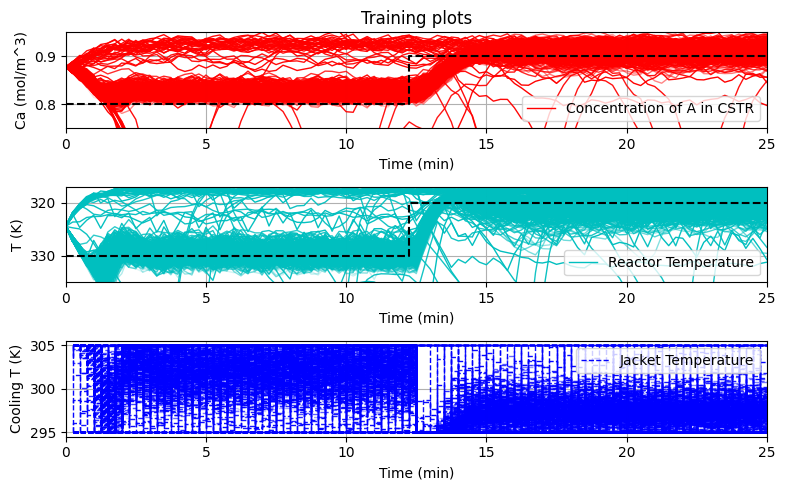

In [ ]:
plot_training(data_res, e_tot)

Notice that the 'input size' below has an extra +2. This is because we must pass the information to the policy network about the setpoint (given that our setpoint will change). Therefore, we give 2 extra inputs to our policy network, one for each setpoint.

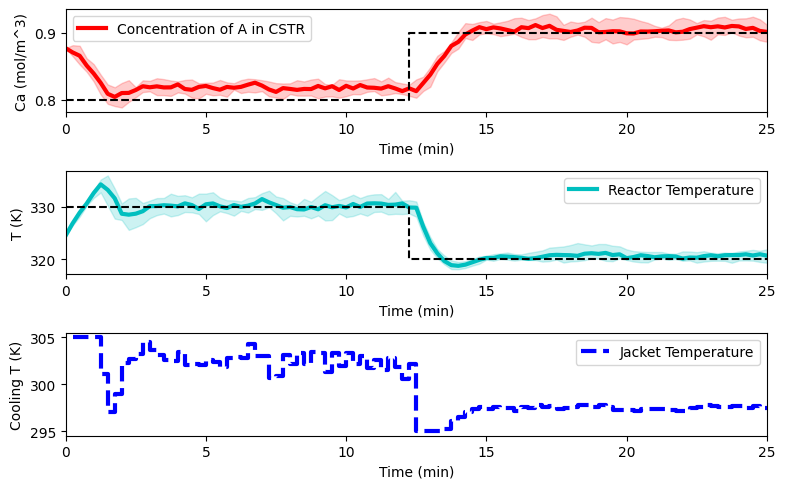

In [ ]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

### Remarks on stochastic policy search

As it can be observed from the simple example above Stochastic local search methods work well in practice and are much easier to implement that other techniques (such as policy gradients). In general, as we move to large parameter spaces, for example neural networks with millions of parameters, their performance will deteriorate, and a policy gradient-like approach will be more desireable. 

## Policy Gradients 🗻

Policy gradient methods rely on the [Policy Gradient Theorem](https://link.springer.com/article/10.1007/BF00992696) which allows to retrieve the gradient of the expected objective function with respect to policy parameters (neural network weights) $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ through Monte Carlo runs. Given the availability of gradients, it is possible to follow a gradient-based optimization to optimize the policy, generally, Adam or Gradient Descent is used. More information can be found of Chapter 13 on [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html). 

In this tutorial notebook we outline the simplest algorithm of this kind, **Reinforce**. For a more in dept introduction to the topic see [Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In the case of stochastic policies, the policy function returns the defining parameters of a probability distribution (such as the mean and variance) over possible actions, from which the actions are sampled: 
$$\textbf{u} \sim \pi_\theta(\textbf{u} | \textbf{x}) = \pi(\textbf{u} | \textbf{x}, \theta) = p(\textbf{u} | \textbf{x}, \theta)$$

Note*: this is the same as the stochastic policy introduced earlier, following the 'probability notation'.

To learn the optimal policy, we seek to maximize our performance metric, and hence we can follow a gradient ascent strategy: 
$$\theta_{m+1} = \theta_m + \alpha_m \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] $$

where $m$ is the current iteration that the parameters are updated (epoch), $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ is the expectation of $f$ over $\pi_\theta$ and $\alpha_m$ is the step size (also termed learning rate in the RL community) for the $m^{th}$ iteration. 

Computing $ \nabla_\theta \hat{f}(\theta) = \nabla_\theta\mathbb{E}_{\pi_\theta}[J(\pi_\theta)]$ directly is difficult, therefore we use the Policy Gradient Theorem, which shows the following:


$$ \begin{alignat}{3}
\nabla_\theta\hat{f}(\theta) = \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] &~=~\nabla_\theta \int  p(\pi_\theta|\theta)~ f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\int \nabla_\theta p(\pi_\theta|\theta)~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \frac{\nabla_\theta p(\pi_\theta|\theta)}{p(\pi_\theta|\theta)~} ~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
\end{alignat} $$

Notice from the first expression, that, $p(\pi_\theta|\theta)~ f(\pi_\theta)$ is an objective function value multiplied by its probability density, therefore, integrating this over all possible values of $\pi_\theta$ we obtain the expected value. From there, using simple algebra, logarithms and the chain rule, we arrive at the final equations, which shows an expected value, where, dropping the explicit distribution of $\pi_\theta$, gives us an unbiased gradient estimator, our steepest ascent update now becomes:

$$ \theta_{m+1} = \theta_m + \alpha_m \mathbb{E}_{\pi_\theta}\left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right] 
$$

Using the expression for $p(\pi_\theta|\theta) = \hat{\mu}(\textbf{x}_0) \prod_{t=0}^{T-1} \left[\pi(\textbf{u}_t|\textbf{x}_t,\theta) p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t) \right]$ and taking its logarithm, we obtain:

$$\nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) = \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)$$

Note that since $p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t)$ and $\hat{\mu}(\textbf{x}_0)$ are independent of $\theta$ they disappear from the above expression. Then we can rewrite for a trajectory as:

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] = \mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right]$$

The above expression does not require the knowledge of the dynamics of the physical system. Monte-Carlo method is utilized to approximate the expectation.

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} \left( f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right)$$


**Reinforce algorithm**

${\bf Input:}$ Initialize policy parameter $\theta = \theta_0$, with $\theta_0\in\Theta_0$, learning rate $\alpha$, set number of episodes $K$ and number of epochs $N$.

${\bf Output:}$ policy $\pi(\cdot | \cdot ,\theta)$ and $\Theta$
\smallskip

${\bf for}$ $m = 1,\dots, N$ ${\bf do}$


1.   Collect $\textbf{u}_t^k , \textbf{x}_t^k,f(\pi_\theta^k)$ for $K$ trajectories of $T$ time steps.
2.   Estimate the gradient $ \hat{g}_m := \frac{1}{K} \sum_{k=1}^{K}  \left[ f(\pi_\theta^k) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t^k|\hat{\textbf{x}}_t^k,\theta)\right)\right]$
3.   Update the policy using a policy gradient estimate $\theta_{m+1} = \theta_m + \alpha_m \hat{g}_m$
4.   $m:=m+1$

${\bf Remark}$: The above algorithm is the base version for many further developments that have been made since it was first proposed. 

The steps of the algorithm are explained below:

${\bf Initialization:}$ The policy network and its weights $\theta$ are initialized along with the algorithm's hyperparameters such as learning rate, number of episodes and number of epochs.

${\bf Training ~~ loop:}$ The weights of the policy network are updated by a policy gradient scheme for a total of $N$ epochs. 

In ${\bf Step 1}$ $K$ trajectories are computed, each trajectory consists of $T$ time steps, and states and control actions are collected. 

In ${\bf Step 2}$ the gradient of the objective function with respect to the weights for the policy network is computed. 

In ${\bf Step 3}$ the weights of the policy network are updated by a gradient ascent scheme. Note that here we show a steepest ascent-like update, but other first order (i.e. Adam) or trust region methods can be used (i.e. PPO, TRPO). 

In ${\bf Step 4}$, either the algorithm terminates or returns to Step 1.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.distributions import MultivariateNormal

In order to implement and apply the Reinforce algorithm, we are going to perform the following steps in the following subsections:


*   Create a [policy network](#policy_net) that uses transfer learning
*   Create an auxiliary function that selects [control actions](#control_actions) out of the distribution
*   Create an auxilary function that runs [multiple episodes](#multi_episodes) per epoch
*   Finally, put all the pieces together into a function that computes the [Reinforce algorithm](#r_alg)



<a name="policy_net"></a>
### Policy network


In the next section of this tutorial notebook we show an implementation from scratch of a policy optimization algorithm using policy gradients.

Given that we have already optimized the policy via stochastic search in the previous section, we use those parameters as a starting point for policy gradients. This is a form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.), which refers to applying knowledge that was previously gained while solving one task to a related task. 

Related to this transfer learning process, we will create a second neural network with the exact same configuration as before, but we will add an extra node to each output of the original neural network to account for the variance term. This is because previously our neural network policy had the structure:

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and by a Stochastic search algorithm we manipulated the weights $\boldsymbol{\theta}$ to optimize performance. In policy gradients we output a distribution, rathen than a single value, in this case we output the mean and the variance of a normal distribution (each output now has two values, the mean and the variance), and therefore we must add an extra node to each output such that we have:

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := \pi({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$



In [ ]:
#########################################
# Policy Network with transfer learning #
#########################################

class Net_TL(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net_TL, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary 
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # Define ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2 

    # Define layers 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

  def increaseClassifier(self, m:torch.nn.Linear):
    w         = m.weight
    b         = m.bias
    old_shape = m.weight.shape

    m2        = nn.Linear( old_shape[1], old_shape[0] + 1)
    m2.weight = nn.parameter.Parameter( torch.cat( (m.weight, m2.weight[0:1]) ), 
                                       requires_grad=True )
    m2.bias   = nn.parameter.Parameter( torch.cat( (m.bias, m2.bias[0:1]) ), 
                                       requires_grad=True)
    return m2
  
  def incrHere(self): 
    self.output = self.increaseClassifier(self.output)

Notice that just as before, we ad a +2 to the input, as thisrefers to the current set-point value.

In [ ]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2

policy_net_pg = Net_TL(**hyparams, requires_grad=True, retain_graph=True)
policy_net_pg.load_state_dict(best_policy) # Transfer learning
policy_net_pg.incrHere()

<a name="control_actions"></a>
### Control action selection


In [ ]:
################################
# action selection from Normal #
################################

def select_action(control_mean, control_sigma):
    """
    Sample control actions from the distribution their distribution
    input: Mean, Variance
    Output: Controls, log_probability, entropy
    """
    s_cov          = control_sigma.diag()**2
    dist           = MultivariateNormal(control_mean, s_cov)
    control_choice = dist.sample()                 # sample control from N(mu,std)
    log_prob       = dist.log_prob(control_choice) # compute log prob of this action (how likely or unlikely)
    entropy        = dist.entropy()                # compute the entropy of the distribution N(mu, std)
    
    return control_choice, log_prob, entropy

#########################
# un-normalizing action #
#########################

def mean_std(m, s, mean_range=[10], mean_lb=[295], std_range=[0.001]):
    '''
    Problem specific restrictions on predicted mean and standard deviation.
    '''
    mean = Tensor(mean_range) * m/6 + Tensor(mean_lb) # ReLU6
    std  = Tensor(std_range)  * s/6
    
    return mean, std

<a name="multi_episodes"></a>
### Multiple episodes - one epoc/training step


In [ ]:
################
# one epoc run #
################

def epoc_run(NNpolicy, episodes_n):
    '''This function runs episodes_n episodes and collected the data. This data
    is then used for one gradient descent step.

    INPUTS
    NNpolicy:   the NN policy
    episodes_n: number of episodes per epoc (gradient descent steps)
    data_train: dictionary of data collected

    OUTPUTS
    data_train: collected data to be passed to the main training loop
    '''

    # run episodes
    logprobs_list = [] # log probabilities is the policies itself p(a|s)
    reward_list   = [] # reward
    for epi_i in range(episodes_n):
        reward_, sum_logprob = J_PolicyCSTR(NNpolicy, policy_alg='PG_RL', 
                                            collect_training_data=True, episode=True)
        logprobs_list.append(sum_logprob)
        reward_list.append(reward_)

    # compute mean and expectation of rewards
    reward_m   = np.mean(reward_list)
    reward_std = np.std(reward_list)
    

    # compute the baseline (reverse sum)
    log_prob_R = 0.0
    for epi_i in reversed(range(episodes_n)):
        baselined_reward = (reward_list[epi_i] - reward_m) / (reward_std + eps)
        log_prob_R       = log_prob_R - logprobs_list[epi_i] * baselined_reward

    # mean log probability
    mean_logprob = log_prob_R/episodes_n
    reward_std   = reward_std
    reward_m     = reward_m

    return mean_logprob, reward_std, reward_m 

<a name="r_alg"></a>
### Reinforce algorithm

Now, let's create a function that put all pieces together and implements the Reinforce algorithm explained above

In [ ]:
def Reinforce(policy, optimizer, n_epochs, n_episodes):

    # lists for plots
    rewards_m_record = []; rewards_std_record = []

    for epoch_i in range(n_epochs):

        # collect data
        mean_logprob, reward_std, reward_m = epoc_run(policy, n_episodes)

        # Expected log reward 
        E_log_R = mean_logprob
        optimizer.zero_grad()
        E_log_R.backward()
        optimizer.step()

        # save data for analysis
        rewards_m_record.append(reward_m)
        rewards_std_record.append(reward_std)

        # schedule to reduce lr
        scheduler.step(E_log_R)

        if epoch_i%int(n_epochs/10)==0:
            mean_r = reward_m
            std_r  = reward_std
            print('epoch:', epoch_i)
            print(f'mean reward: {mean_r:.3} +- {std_r:.2}')

    return rewards_m_record, rewards_std_record, policy

### Apply the Reinforce algorithm

Now that we have the algorithm, let's apply it to the problem. 

Let's choose some problem parameters and initialize storing lists

In [ ]:
# problem parameters
lr         = 0.0001
total_it   = 2000
n_episodes = 50
n_epochs   = int(total_it/n_episodes)

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

define the policy and the optimizer to be used

In [ ]:
# define policy and optimizer
control_policy = policy_net_pg
optimizer_pol  = optim.Adam(control_policy.parameters(), lr=lr)

define the learning rate scheduler

In [ ]:
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pol, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)

and apply the algorithm

```{note} Runing the algorithm will last for a few minutes
```

In [ ]:
rewards_m_record, rewards_std_record, optimal_Reinforce = \
Reinforce(control_policy, optimizer_pol, n_epochs, n_episodes)

epoch: 0
mean reward: -21.6 +- 1.1
epoch: 4
mean reward: -22.0 +- 1.3
epoch: 8
mean reward: -21.9 +- 1.2
epoch: 12
mean reward: -21.7 +- 1.0
epoch: 16
mean reward: -21.8 +- 1.1
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
epoch: 20
mean reward: -21.5 +- 1.2
epoch: 24
mean reward: -22.0 +- 1.3
epoch: 28
mean reward: -21.9 +- 1.2
epoch: 32
mean reward: -21.8 +- 1.1
epoch: 36
mean reward: -21.7 +- 1.1


Let's visualize now

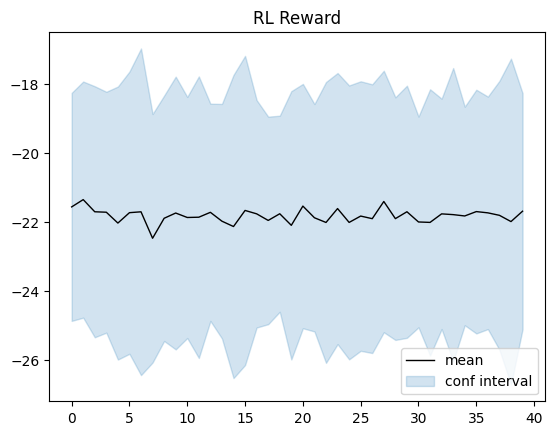

In [ ]:
# plot the samples of posteriors
plt.plot(rewards_m_record, 'black', linewidth=1)
# plot GP confidence intervals
iterations = [i for i in range(len(rewards_m_record))]
plt.gca().fill_between(iterations, np.array(rewards_m_record) - 3*np.array(rewards_std_record), 
                       np.array(rewards_m_record) + 3*np.array(rewards_std_record), 
                       color='C0', alpha=0.2)
plt.title('RL Reward')
plt.legend(('mean', 'conf interval'),
           loc='lower right')
plt.show()

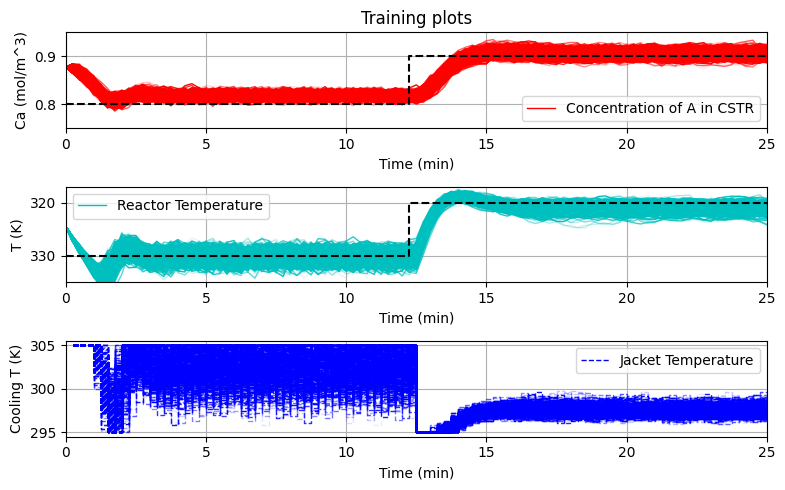

In [ ]:
plot_training(data_res, e_tot)

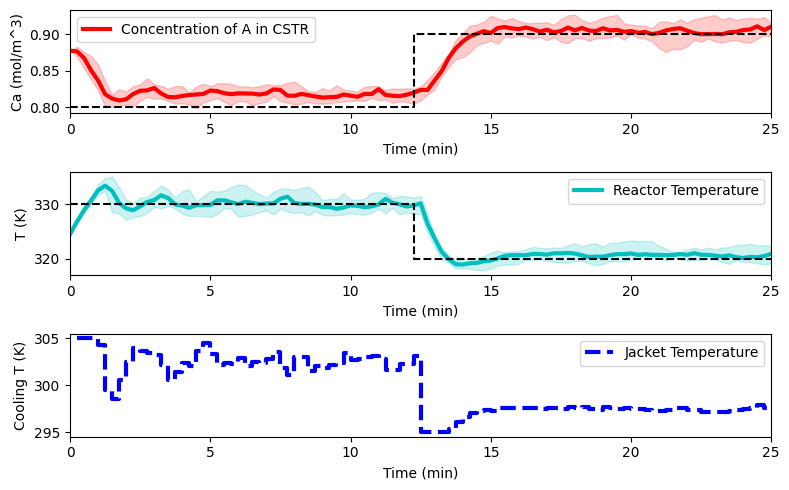

In [ ]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_pg,
                                                               policy_alg='PG_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Extra material on RL for ChemEng 🤓

If you would like to read more about the use of reinforcement learning in chemical engineering systems:

**Applications** 

*   Reinforcement learning offers potential for bringing significant improvements to [industrial batch process control practice](https://www.sciencedirect.com/science/article/abs/pii/S136757882100081X) even in [discontinous and nonlinear systems](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168).
*   RL has also been used to address [chemical production scheduling](https://www.sciencedirect.com/science/article/pii/S0098135420301599) and [multi-echelon supply chains](https://www.sciencedirect.com/science/article/pii/S2772508122000643)
*   Other applications include [PID tuning](https://www.sciencedirect.com/science/article/abs/pii/S0967066121002963), [real-time optimization](https://www.mdpi.com/2227-9717/11/1/123), [searching for optimal process routes](https://www.sciencedirect.com/science/article/abs/pii/S0098135420303999), [flowsheet generation](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17938), [bioreactors](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168) and [biotherapeutics](https://onlinelibrary.wiley.com/doi/10.1002/bit.28346), amongst many others.

**Methodologies** 

*   Constraints to address [plant-model mismatch](https://www.sciencedirect.com/science/article/abs/pii/S0098135421004087), [constrained Q-learning](https://www.sciencedirect.com/science/article/abs/pii/S0098135421002404), [safe reinforcement learning](https://www.researchgate.net/publication/368302457_Safe_deployment_of_reinforcement_learning_using_deterministic_optimization_of_trained_neural_networks), satisfaction of constraints with [high probability](https://www.sciencedirect.com/science/article/pii/S0959152422000038), and [dynamic penalties](https://www.sciencedirect.com/science/article/pii/S0959152422000816) for better convergence.
*   [Process control](https://www.mdpi.com/2227-9717/10/11/2311), [meta-reinforcement learning](https://www.sciencedirect.com/science/article/pii/S0959152422001445), [general economic process control](https://www.sciencedirect.com/science/article/pii/S0098135420307912), amongst many many others. 

 